# Module Imports

In [5]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import nibabel as nb
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm

from cca_zoo.models import MCCA
from matplotlib import cm, gridspec, colors
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from utils.glm_utils import linear_regression, get_hrf, convolve_hrf, onsets_to_block
from utils.notebook_utils import commonality_analysis, evaluate_model, lag_basis, \
load_pca_results, load_subj_chang, load_subj_chang_bh, load_subj_hcp, load_subj_nki, \
load_subj_spreng, timeseries_cv, fs_chang, fs_hcp, fs_nki, fs_spreng, xcorr
from utils.signal.butterworth_filters import butterworth_filter
from utils.stationary_block_bootstrap import resample as ts_resample
from utils.load_write import  convert_2d, load_data, load_nki_event_file, write_nifti
from run_taskbh_chang_analysis import construct_deep_breath_blocks, load_chang_bh_event_file
from run_taskbh_nki_analysis import construct_task_blocks
from patsy import dmatrix
from pygam import LinearGAM, LogisticGAM, te, s, f
from scipy.signal import hilbert
from scipy.interpolate import interp1d
from scipy.stats import zscore, gaussian_kde
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit


# 1. Load Subject List and PCA Time Courses

## 1.1 Subject Lists

In [8]:
subject_list_hcp = pd.read_csv('data/dataset_hcp/subject_list_hcp_rest.csv')
subject_list_chang = pd.read_csv('data/dataset_chang/subject_list_chang.csv')
subject_list_nki = pd.read_csv('data/dataset_nki/subject_list_nki.csv')
subject_list_chang_bh = pd.read_csv('data/dataset_chang_bh/subject_list_chang_bh.csv')
subject_list_spreng = pd.read_csv('data/dataset_spreng/subject_list_spreng.csv')

## 1.2. Load PCA Time Courses

In [9]:
chang_pca_fps = ['results/pca/chang_pca_group_results.pkl', 'results/pca/chang_pca_group_promax_results.pkl']
chang_len = 693
pc_subj_chang, pc_p_subj_chang = load_pca_results(subject_list_chang, chang_pca_fps[0], chang_pca_fps[1], 
                                                  chang_len, scan_ind=True)

chang_bh_pca_fps = ['results/pca/chang_bh_pca_group_results.pkl', 'results/pca/chang_bh_pca_group_promax_results.pkl']
chang_bh_len = 423
pc_subj_chang_bh, pc_p_subj_chang_bh = load_pca_results(subject_list_chang_bh, chang_bh_pca_fps[0],
                                                        chang_bh_pca_fps[1], chang_bh_len, scan_ind=True)

hcp_pca_fps = ['results/pca/hcp_fix_pca_group_results.pkl', 'results/pca/hcp_fix_pca_group_promax_results.pkl']
hcp_len = 1200
pc_subj_hcp, pc_p_subj_hcp = load_pca_results(subject_list_hcp, hcp_pca_fps[0], hcp_pca_fps[1], hcp_len)

nki_pca_fps = ['results/pca/nki_pca_group_results.pkl', 'results/pca/nki_pca_group_promax_n10_results.pkl']
nki_len = 186
pc_subj_nki, pc_p_subj_nki = load_pca_results(subject_list_nki, nki_pca_fps[0], nki_pca_fps[1], nki_len)

spreng_pca_fps = ['results/pca/spreng_pca_group_results.pkl', 'results/pca/spreng_pca_group_promax_results.pkl']
spreng_len = 200
pc_subj_spreng, pc_p_subj_spreng = load_pca_results(subject_list_spreng, spreng_pca_fps[0], spreng_pca_fps[1], spreng_len)

In [164]:
pca_output = pickle.load(open(f'results/pca/chang_bh_pca_group_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/chang_bh_pca_group_promax_results.pkl', 'rb'))

pc_ts = pca_output['pc_scores']
pc_ts_p = pca_output_p['pc_scores']

n_t = 0
n_shift = 423
pc_subj_chang_bh = {}
pc_p_subj_chang_bh = {}
for i, (subj, scan, n_shift) in enumerate(
    zip(subject_list_chang_bh.subject, subject_list_chang_bh.scan, subject_list_chang_bh.nframes)
):
    # Extract subject PC time series
    pc_subj_chang_bh[f'{subj}_{scan}'] = pc_ts[n_t:(n_t+n_shift),:]
    # Extract subject PC-Promax time series
    pc_p_subj_chang_bh[f'{subj}_{scan}'] = pc_ts_p[n_t:(n_t+n_shift),:]
    n_t += n_shift
    

# 2. Figure 2 - Pattern One, CSF Flow and PPG Low-Frequency

## 3.1 Summary of Subject-Level CSF and PC1 Cross-Correlation

### 3.1.1 Chang Dataset

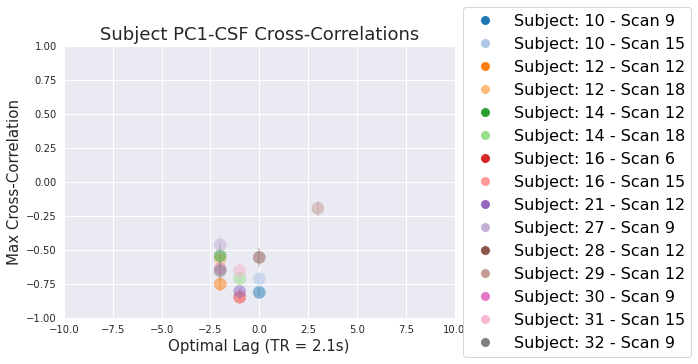

In [167]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    max_r, max_lag = xcorr(df['csf'], df['pc1'], maxlags=10, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['csf'].values, df['pc1'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], maxlags=10, constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj} - Scan {scan}' 
               for subj, scan in zip(subject_list_chang.iloc[:, 0], subject_list_chang.iloc[:, 1])]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-10,10])
    ax.set_xlabel('Optimal Lag (TR = 2.1s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1-CSF Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

recs = []
for i in range(0,len(c_subj)):
    recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

### 3.1.2 HCP Dataset

In [6]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'], fs_hcp, norm=True)
    max_r, max_lag = xcorr(df['csf'], df['pc1'], maxlags=25, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['csf'].values, df['pc1'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], maxlags=25, constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj}' for subj in subject_list_hcp.iloc[:, 0]]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-25,25])
    ax.set_xlabel('Optimal Lag (TR = 0.72s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1-CSF Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

recs = []
for i in range(0,len(c_subj)):
    recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

OSError: data/dataset_hcp/physio/proc1_physio/102311_csf.txt not found.

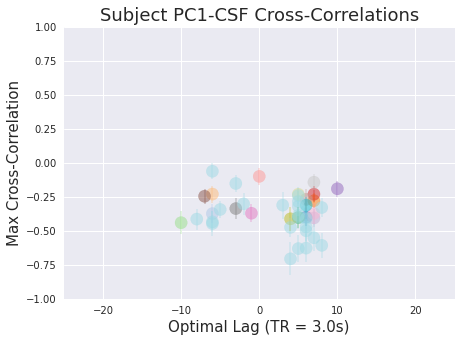

In [22]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_spreng.shape[0]):
    # Load Subject
    subj = subject_list_spreng.iloc[i, 1]
    df = load_subj_spreng(subj, pc_subj_spreng[f'{subj}'], pc_p_subj_spreng[f'{subj}'], fs_spreng, norm=True)
    max_r, max_lag = xcorr(df['PPG_RMS_AMP'], df['pc1'], maxlags=10, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['PPG_RMS_AMP'].values, df['pc1'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], maxlags=25, constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj}' for subj in subject_list_spreng.iloc[:, 1]]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(7,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-25,25])
    ax.set_xlabel('Optimal Lag (TR = 3.0s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1-CSF Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)


## 3.2 Summary of Subject Level PPG-LOW and PC1 Cross-Correlation

### 3.2.1 Chang Dataset

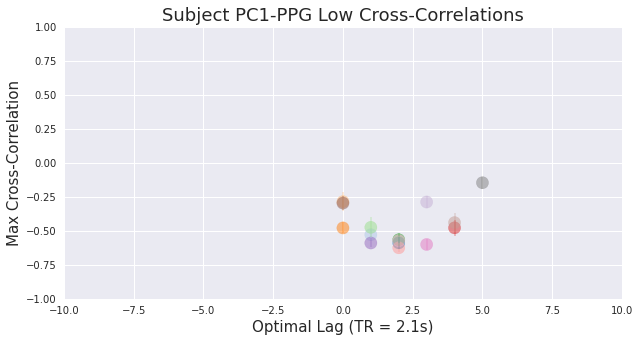

In [16]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    max_r, max_lag = xcorr(df['PPG_LOW_NK'], df['pc1'], maxlags=10, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['PPG_LOW_NK'].values, df['pc1'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj} - Scan {scan}' 
               for subj, scan in zip(subject_list_chang.iloc[:, 0], subject_list_chang.iloc[:, 1])]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(10,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-10,10])
    ax.set_xlabel('Optimal Lag (TR = 2.1s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1-PPG Low Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

# recs = []
# for i in range(0,len(c_subj)):
#     recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
# plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

### 3.2.2 HCP Dataset

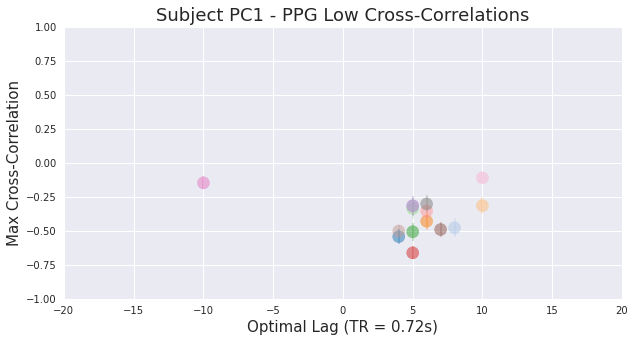

In [175]:
n_bootstraps=100
bootstrap_r = []
max_r_all = []
max_lag_all = []
# Loop through subjects and run regression
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'], fs_hcp, norm=True)
    max_r, max_lag = xcorr(df['PPG_RMS_AMP'], df['pc1'], maxlags=20, constrain='neg')
    max_r_all.append(max_r)
    max_lag_all.append(max_lag)
    X = np.vstack([df['PPG_RMS_AMP'].values, df['pc1'].values]).T
    subj_r = []
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        max_r_b, _ = xcorr(X_b[:,0], X_b[:,1], constrain='neg')
        subj_r.append(max_r_b)
    bootstrap_r.append(np.std(subj_r))

cmap = cm.get_cmap('tab20')
subj_labels = [f'Subject: {subj}' for subj in subject_list_hcp.iloc[:, 0]]
c_subj = [cmap(i) for i in range(len(subj_labels))]

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(figsize=(10,5), constrained_layout=False)
    ax.scatter(max_lag_all, max_r_all, s=150, alpha=0.5, 
               c=c_subj, label=subj_labels)
    ax.errorbar(max_lag_all, max_r_all, 
                yerr=bootstrap_r, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([-1,1])
    ax.set_xlim([-20,20])
    ax.set_xlabel('Optimal Lag (TR = 0.72s)', fontsize=15)
    ax.grid(True)
    ax.set_title('Subject PC1 - PPG Low Cross-Correlations', fontweight='bold', fontsize=18)
    ax.set_ylabel('Max Cross-Correlation', fontsize=15)

# recs = []
# for i in range(0,len(c_subj)):
#     recs.append(Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor=c_subj[i]))
# plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)

# 4. Figure 3 - Pattern One Sub-Structure

## 4.1 Chang Dataset

### 4.1.1 Load PCA Time Courses

In [10]:
pca_p = pickle.load(open('results/pca/chang_pca_group_promax_results.pkl', 'rb'))
pca = pickle.load(open('results/pca/chang_pca_group_results.pkl', 'rb'))

### 4.1.2 Cross-Correlations

Text(0.5, 1.0, 'PC1 - PC3 Promax \nCross-Corr')

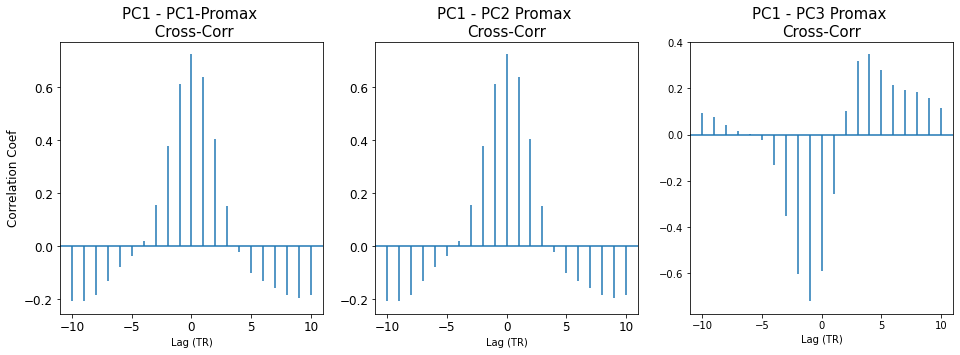

In [11]:
fig, axs = plt.subplots(1,3, figsize=(16,5))
axs[0].xcorr(pca['pc_scores'][:,0], pca_p['pc_scores'][:,1], maxlags=10)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_xlabel('Lag (TR)')
axs[0].set_ylabel('Correlation Coef', fontsize=12)
axs[0].set_title('PC1 - PC1-Promax \n Cross-Corr', fontsize=15)

axs[1].xcorr(pca['pc_scores'][:,0], pca_p['pc_scores'][:,1], maxlags=10)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_xlabel('Lag (TR)')
axs[1].set_title('PC1 - PC2 Promax \nCross-Corr', fontsize=15)

axs[2].xcorr(pca['pc_scores'][:,0], pca_p['pc_scores'][:,2], maxlags=10)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[2].set_xlabel('Lag (TR)')
axs[2].set_title('PC1 - PC3 Promax \nCross-Corr', fontsize=15)

### 4.1.3 Time Course Correlations with Pattern One

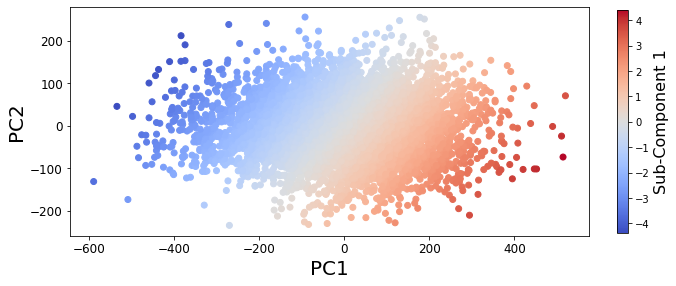

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,0], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Sub-Component 1', fontsize=16)

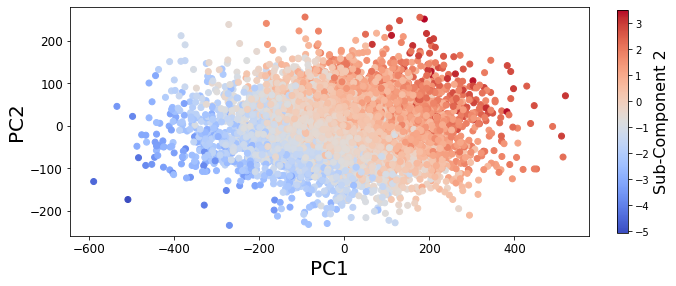

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,1], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Sub-Component 2', fontsize=16)

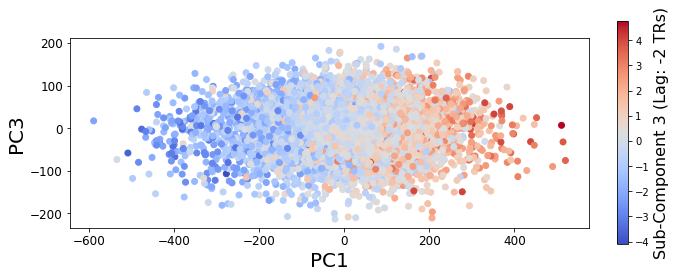

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,2], 
               c=np.roll(pca_p['pc_scores'][:,2]*-1, -2), cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC3', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Sub-Component 3 (Lag: -2 TRs)', fontsize=16)

In [15]:
df = pd.DataFrame(np.hstack([pca['pc_scores'][:,0][:,np.newaxis], pca_p['pc_scores']]), 
                  columns=['PC1', 'PC1_P','PC2_P', 'PC3_P'])
df['PC3_P_Shift'] = df['PC3_P'].shift(-1)
df[['PC1', 'PC1_P','PC2_P', 'PC3_P_Shift']].corr()

,PC1,PC1_P,PC2_P,PC3_P_Shift
PC1,1.000000,0.913638,0.722953,-0.721784
PC1_P,0.913638,1.000000,0.447855,-0.552763
PC2_P,0.722953,0.447855,1.000000,-0.484165
PC3_P_Shift,-0.721784,-0.552763,-0.484165,1.000000


## 4.2 HCP Dataset

### 4.2.1 Zero-lag Correlations

In [198]:
pca_p = pickle.load(open('results/pca/hcp_pca_group_promax_results.pkl', 'rb'))
pca = pickle.load(open('results/pca/hcp_pca_group_results.pkl', 'rb'))

pca['pc_scores'][:,0] = pca['pc_scores'][:,0]*-1 # Make consisent with Chang PC1
pca_p['pc_scores'][:,0] = pca_p['pc_scores'][:,0]*-1 # Make consisent with Chang PC1

### 4.2.2 Cross-Correlations

Text(0.5, 1.0, 'PC2 Promax - PC3 Promax \nCross-Corr')

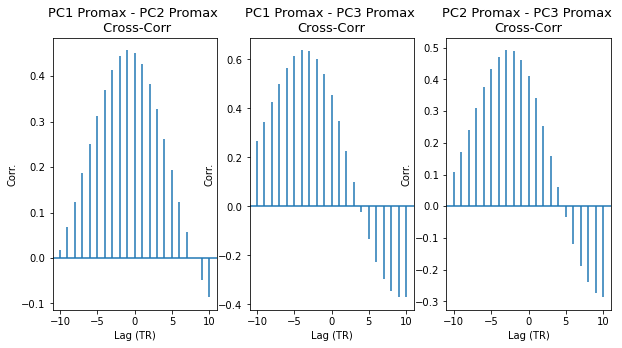

In [199]:
fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].xcorr(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,1], maxlags=10)
axs[0].set_xlabel('Lag (TR)')
axs[0].set_ylabel('Corr.')
axs[0].set_title('PC1 Promax - PC2 Promax \n Cross-Corr', fontsize=13)

axs[1].xcorr(pca_p['pc_scores'][:,0], pca_p['pc_scores'][:,2], maxlags=10)
axs[1].set_xlabel('Lag (TR)')
axs[1].set_ylabel('Corr.')
axs[1].set_title('PC1 Promax - PC3 Promax \nCross-Corr', fontsize=13)

axs[2].xcorr(pca_p['pc_scores'][:,1], pca_p['pc_scores'][:,2], maxlags=10)
axs[2].set_xlabel('Lag (TR)')
axs[2].set_ylabel('Corr.')
axs[2].set_title('PC2 Promax - PC3 Promax \nCross-Corr', fontsize=13)

### 4.2.3 Correlations with Pattern One

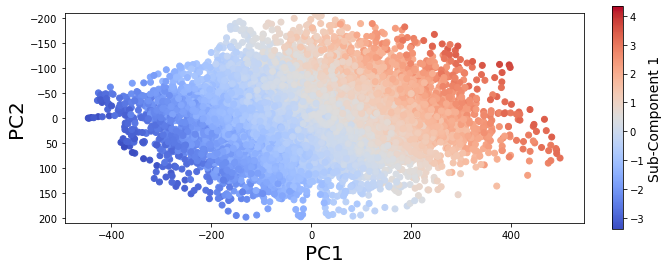

In [200]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,0], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_ylim(210, -210)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Sub-Component 1', fontsize=14)

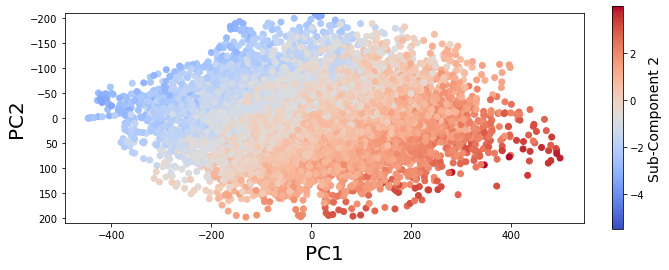

In [201]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,1], c=pca_p['pc_scores'][:,1], cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_ylim(210, -210)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Sub-Component 2', fontsize=14)

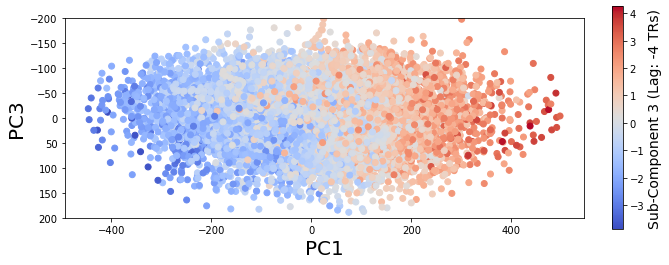

In [202]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.scatter(pca['pc_scores'][:,0], pca['pc_scores'][:,2], c=np.roll(pca_p['pc_scores'][:,2], -4), cmap='coolwarm')
ax.axis('scaled')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC3', fontsize=20)
ax.set_ylim(200, -200)
cbar = plt.colorbar(p, ax=ax, fraction=0.02)
cbar.set_label('Sub-Component 3 (Lag: -4 TRs)', fontsize=14)

In [203]:
df = pd.DataFrame(np.hstack([pca['pc_scores'][:,0][:,np.newaxis], pca_p['pc_scores']]), 
                  columns=['PC1', 'PC1_P','PC2_P', 'PC3_P'])
df['PC3_P_Shift'] = df['PC3_P'].shift(-4)
df[['PC1', 'PC1_P','PC2_P', 'PC3_P_Shift']].corr()

,PC1,PC1_P,PC2_P,PC3_P_Shift
PC1,1.000000,0.895785,0.709275,0.748299
PC1_P,0.895785,1.000000,0.450732,0.636730
PC2_P,0.709275,0.450732,1.000000,0.472004
PC3_P_Shift,0.748299,0.636730,0.472004,1.000000


# 5. Figure 4. A Complex Unified Response to Respiration Amplitude Fluctuations.

## 5.1 NKI Breathhold Task

### 5.2.1 PCA Scan Average

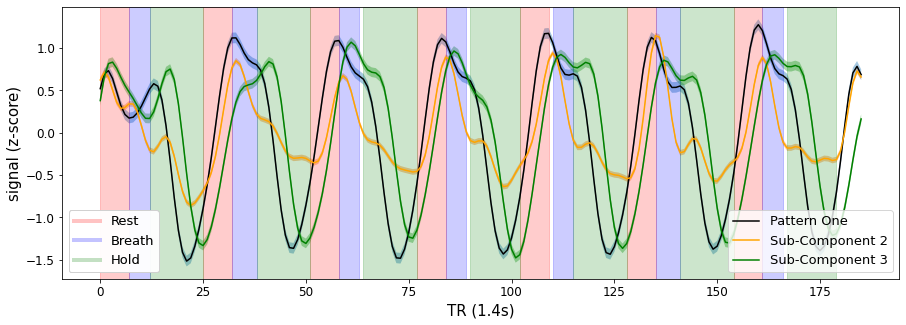

In [20]:
ppg_avg = []
pc_avg = []
pc6_avg = []
pc8_avg = []
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'], fs_nki, norm=True)
    pc_avg.append(df['pc1'].values)
    pc6_avg.append(df['pc6_p'].values)
    pc8_avg.append(df['pc8_p'].values)

    
pc_avg = np.array(pc_avg).mean(axis=0)
pc_se = np.array(pc_avg).std(axis=0) / np.sqrt(np.size(pc_avg))
pc6_avg = np.array(pc6_avg).mean(axis=0)
pc6_se = np.array(pc6_avg).std(axis=0) / np.sqrt(np.size(pc6_avg))
pc8_avg = np.array(pc8_avg).mean(axis=0)
pc8_se = np.array(pc8_avg).std(axis=0) / np.sqrt(np.size(pc8_avg))


fig, ax = plt.subplots(figsize=(15,5))
ax.plot(pc_avg, color='k')
ax.fill_between(np.arange(len(pc_avg)), pc_avg-pc_se, pc_avg+pc_se, alpha=0.4)
ax.plot(pc8_avg, color='orange')
ax.fill_between(np.arange(len(pc8_avg)), pc8_avg-pc8_se, pc8_avg+pc8_se, alpha=0.4)
ax.plot(pc6_avg, color='green')
ax.fill_between(np.arange(len(pc6_avg)), pc6_avg-pc6_se, pc6_avg+pc6_se, alpha=0.4)


lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(3)], 
                     ['Pattern One', 'Sub-Component 2', 'Sub-Component 3'], 
                     loc=4, fontsize=13)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=3, fontsize=13)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

## 5.2 Chang Breathing Dataset

### 5.2.1 Create Breath Onset Blocks

In [25]:
bh_events = load_chang_bh_event_file()
bh_event_blocks = construct_deep_breath_blocks(bh_events, 2.1)
bh_event_blocks = [tuple(b) for b in bh_event_blocks]
breath_onsets_tr = [block[0] for block in bh_event_blocks]

### 5.2.2 Load Trial-Level Compliance CSV

In [26]:
compliance = pd.read_csv('data/dataset_chang_bh/compliance.csv')
compliance = compliance.set_index(
    compliance['subject'].astype(str) + '_' + compliance['scan'].astype(str)
)
trial_cols = [f'trial{n+1}' for n in range(9)]

### 5.2.3 PC-Promax Average to Deep Breath Onset

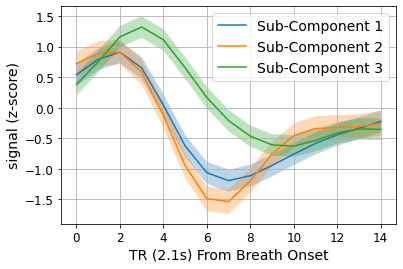

In [51]:
fig, ax = plt.subplots()
signals_avg = ['pc1', 'RESP_AMP_HILBERT']
subj_scan_dict = {
    15: [9, 15],
    17: [6, 15],
    19: [16, 22],
    20: [12],
    21: [9],
    25: [12]
}

group_pc1_avg = []
group_pc2_avg = []
group_pc3_avg = []
for subj in subj_scan_dict:
    pc1_blocks = []; pc2_blocks = []; pc3_blocks = []
    for scan in subj_scan_dict[subj]: 
        if scan < 10:
            scan_str = f'000{scan}'
        else:
            scan_str = f'00{scan}'
        df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang_bh[f'{subj}_{scan}'], 
                                     pc_p_subj_chang_bh[f'{subj}_{scan}'], fs_chang)
        pc1_ts = df_subj['pc1_p'].values[np.newaxis, :]
        pc2_ts = df_subj['pc2_p'].values[np.newaxis, :]
        pc3_ts = df_subj['pc3_p'].values[np.newaxis, :]
        scan_compliance = compliance.loc[f'{subj}_{scan}'][trial_cols].values
        scan_event_blocks = [block for block, c in zip(bh_event_blocks, scan_compliance) if c == 1]
        pc1_blocks.append(np.squeeze(pc1_ts[:,scan_event_blocks]))
        pc2_blocks.append(np.squeeze(pc2_ts[:,scan_event_blocks]))
        pc3_blocks.append(np.squeeze(pc3_ts[:,scan_event_blocks]))
    pc1_blocks = np.vstack(pc1_blocks) 
    pc2_blocks = np.vstack(pc2_blocks)
    pc3_blocks = np.vstack(pc3_blocks)
    group_pc1_avg.append(pc1_blocks.mean(axis=0))
    group_pc2_avg.append(pc2_blocks.mean(axis=0))
    group_pc3_avg.append(pc3_blocks.mean(axis=0))
    
group_pc1_avg = np.mean(group_pc1_avg, axis=0)
group_pc1_se = np.std(group_pc1_avg, axis=0) / np.sqrt(np.size(group_pc1_avg))
group_pc2_avg = np.mean(group_pc2_avg, axis=0)
group_pc2_se = np.std(group_pc2_avg, axis=0) / np.sqrt(np.size(group_pc2_avg))
group_pc3_avg = np.mean(group_pc3_avg, axis=0)
group_pc3_se = np.std(group_pc3_avg, axis=0) / np.sqrt(np.size(group_pc3_avg))

ax.plot(np.arange(15), group_pc1_avg, label='Sub-Component 1')
ax.fill_between(np.arange(15), group_pc1_avg-group_pc1_se, group_pc1_avg+group_pc1_se, alpha=0.3)


ax.plot(np.arange(15), group_pc3_avg, label='Sub-Component 2')
ax.fill_between(np.arange(15), group_pc3_avg-group_pc3_se, group_pc3_avg+group_pc3_se, alpha=0.3)


ax.plot(np.arange(15), group_pc2_avg, label='Sub-Component 3')
ax.fill_between(np.arange(15), group_pc2_avg-group_pc2_se, group_pc2_avg+group_pc2_se, alpha=0.3)



ax.legend(fontsize=14)
ax.grid(True)
ax.set_xlabel('TR (2.1s) From Breath Onset', fontsize=14)
ax.set_ylabel('signal (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

## 5.3 Distributed Lag Non-Linear Modeling of Respiration Amplitude

### 5.3.1 Illustration of Sinusoid for Figure 3

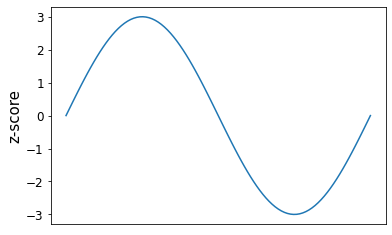

In [52]:
fig, ax = plt.subplots()
ax.plot(np.sin(np.linspace(0, 2*np.pi, 100))*3)
ax.set_xticks([])
ax.set_ylabel('z-score', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

### 5.3.2 Chang Dataset

#### 5.3.2.1 Clustering of High Positive Respiration Amplitude

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


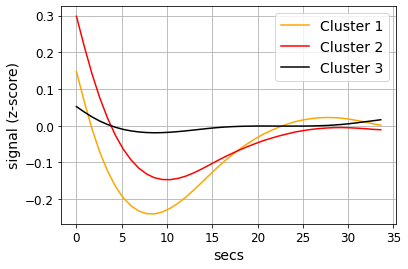

In [56]:
mask_full = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask = mask_full.get_fdata() > 0

nifti = nb.load('results/physio_glm_dlnm/chang_dlnm_group_eval_6_rv.nii', keep_file_open = True)
dlnm_res = pickle.load(open('results/physio_glm_dlnm/chang_dlnm_group_rv_results.pkl', 'rb'))
nifti_data = nifti.get_fdata()
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)
# nan_mask = ~(np.isnan(nifti_data).any(axis=0))

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(nifti_data.T)

fig, ax = plt.subplots()
ax.plot(dlnm_res[1]*2.1, kmeans.cluster_centers_[0,:], color='orange', label='Cluster 1')
ax.plot(dlnm_res[1]*2.1, kmeans.cluster_centers_[1,:], color='red', label='Cluster 2')
ax.plot(dlnm_res[1]*2.1, kmeans.cluster_centers_[2,:], color='black', label='Cluster 3')
ax.legend(fontsize=14)
ax.set_xlabel('secs', fontsize=14)
ax.set_ylabel('signal (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

#### 5.3.2.2 Clustering of High Negative Respiration Amplitude

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


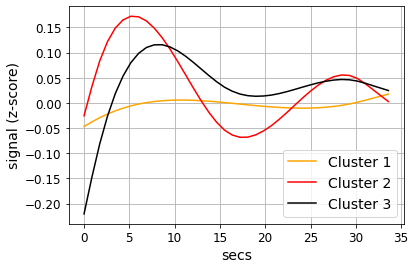

In [59]:
mask_full = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask = mask_full.get_fdata() > 0

nifti = nb.load('results/physio_glm_dlnm/chang_dlnm_group_eval_0_rv.nii', keep_file_open = True)
dlnm_res = pickle.load(open('results/physio_glm_dlnm/chang_dlnm_group_rv_results.pkl', 'rb'))
nifti_data = nifti.get_fdata()
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)
# nan_mask = ~(np.isnan(nifti_data).any(axis=0))

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(nifti_data.T)

fig, ax = plt.subplots()
ax.plot(dlnm_res[1]*2.1, kmeans.cluster_centers_[0,:], color='orange', label='Cluster 1')
ax.plot(dlnm_res[1]*2.1, kmeans.cluster_centers_[1,:], color='red', label='Cluster 2')
ax.plot(dlnm_res[1]*2.1, kmeans.cluster_centers_[2,:], color='black', label='Cluster 3')
ax.legend(fontsize=14)
ax.set_xlabel('secs', fontsize=14)
ax.set_ylabel('signal (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

### 5.3.3 HCP Dataset

#### 5.3.3.1 Clustering of High Positive Respiration Amplitude

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


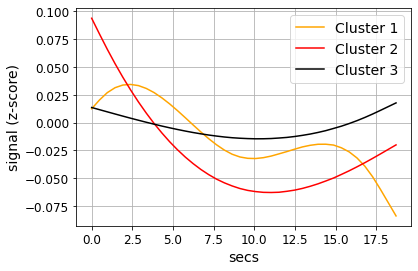

In [62]:
mask_full = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask = mask_full.get_fdata() > 0

nifti = nb.load('results/physio_glm_dlnm/hcp_fix_dlnm_group_eval_6_rv.nii', keep_file_open = True)
dlnm_res = pickle.load(open('results/physio_glm_dlnm/hcp_fix_dlnm_group_rv_results.pkl', 'rb'))
nifti_data = nifti.get_fdata()
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)
# nan_mask = ~(np.isnan(nifti_data).any(axis=0))

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(nifti_data.T)

fig, ax = plt.subplots()
ax.plot(dlnm_res[1]*0.72, kmeans.cluster_centers_[0,:], color='orange', label='Cluster 1')
ax.plot(dlnm_res[1]*0.72, kmeans.cluster_centers_[1,:], color='red', label='Cluster 2')
ax.plot(dlnm_res[1]*0.72, kmeans.cluster_centers_[2,:], color='black', label='Cluster 3')
ax.legend(fontsize=14)
ax.set_xlabel('secs', fontsize=14)
ax.set_ylabel('signal (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

#### 5.3.3.2 Clustering of High Negative Respiration Amplitude

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


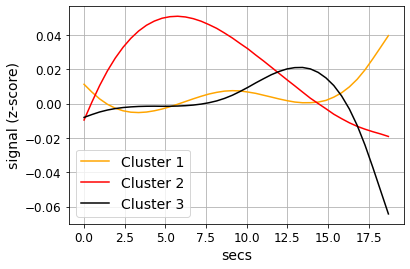

In [63]:
mask_full = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask = mask_full.get_fdata() > 0

nifti = nb.load('results/physio_glm_dlnm/hcp_fix_dlnm_group_eval_0_rv.nii', keep_file_open = True)
dlnm_res = pickle.load(open('results/physio_glm_dlnm/hcp_fix_dlnm_group_rv_results.pkl', 'rb'))
nifti_data = nifti.get_fdata()
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)
# nan_mask = ~(np.isnan(nifti_data).any(axis=0))

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(nifti_data.T)

fig, ax = plt.subplots()
ax.plot(dlnm_res[1]*0.72, kmeans.cluster_centers_[0,:], color='orange', label='Cluster 1')
ax.plot(dlnm_res[1]*0.72, kmeans.cluster_centers_[1,:], color='red', label='Cluster 2')
ax.plot(dlnm_res[1]*0.72, kmeans.cluster_centers_[2,:], color='black', label='Cluster 3')
ax.legend(fontsize=14)
ax.set_xlabel('secs', fontsize=14)
ax.set_ylabel('signal (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

In [120]:
data_write = kmeans.labels_[np.newaxis, :]+1
nifti_4d = np.zeros(mask.shape + (data_write.shape[0],), 
                    dtype=data_write.dtype)
nifti_4d[mask, :] = data_write.T
nifti_out = nb.Nifti2Image(nifti_4d, mask_full.affine)
nb.save(nifti_out, 'hcp_fix_dlnm_group_eval_0_clusters_3.nii')

# 6. Figure 5 - FC Matrix Comparison

## 6.1 Chang Dataset

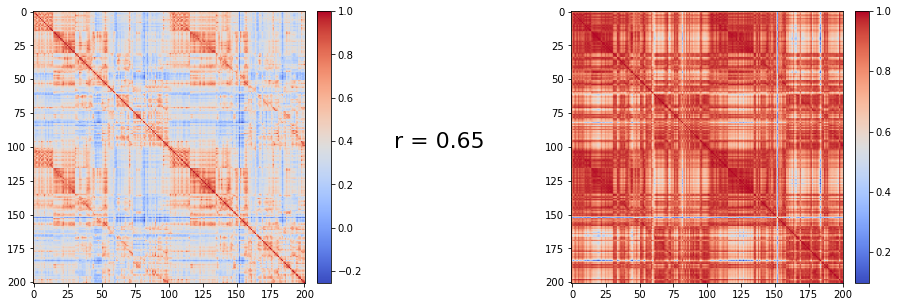

In [82]:
fc_res = pickle.load(open('results/fc_compare/chang_fc_compare_rv_results_schaefer200.pkl', 'rb'))
fc_orig = fc_res[0]
fc_pred = fc_res[1]
fc_orig_l = fc_orig[np.tril_indices_from(fc_orig, k=-1)]
fc_pred_l = fc_pred[np.tril_indices_from(fc_pred, k=-1)]

l_corr = np.corrcoef(fc_orig_l, fc_pred_l)

fig, axs = plt.subplots(1,2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.8)
im = axs[0].imshow(fc_orig, cmap='coolwarm')
plt.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
im = axs[1].imshow(fc_pred, cmap='coolwarm')
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.gcf().text(0.46, 0.5, f'r = {round(l_corr[0,1], 2)}', fontsize = 22)
plt.show()

## 6.2 HCP Dataset

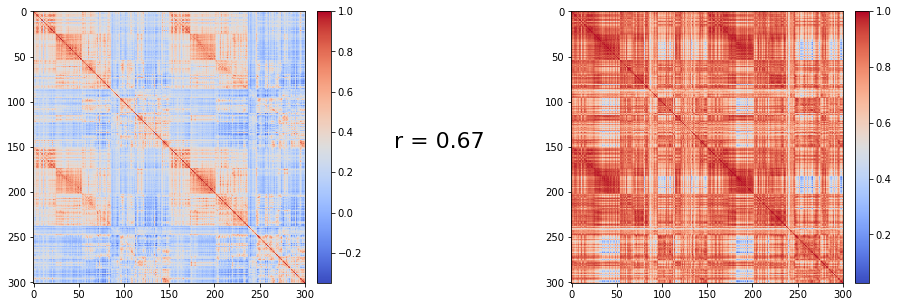

In [83]:
fc_res = pickle.load(open('results/fc_compare/hcp_fix_fc_compare_rv_results_schaefer200.pkl', 'rb'))
fc_orig = fc_res[0]
fc_pred = fc_res[1]
fc_orig_l = fc_orig[np.tril_indices_from(fc_orig, k=-1)]
fc_pred_l = fc_pred[np.tril_indices_from(fc_pred, k=-1)]

l_corr = np.corrcoef(fc_orig_l, fc_pred_l)

fig, axs = plt.subplots(1,2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.8)
im = axs[0].imshow(fc_orig, cmap='coolwarm')
plt.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
im = axs[1].imshow(fc_pred, cmap='coolwarm')
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
plt.gcf().text(0.46, 0.5, f'r = {round(l_corr[0,1], 2)}', fontsize = 22)
plt.show()

# 7. Figure 6. Vigilance Modulation of Pattern One and Respiration Time Courses

## 7.1 Amplitude Analysis

### 7.1.1 Load Dataset (Chang)

In [36]:
df_group = []
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                         fs_chang)
    # Create amplitude time series
    df['RESP_AMP_HILBERT_AMP'] = butterworth_filter(
        np.abs(hilbert(df['RESP_AMP_HILBERT'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['PC1_AMP'] = butterworth_filter(
        np.abs(hilbert(df['pc1'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    df['CSF_AMP'] = butterworth_filter(
        np.abs(hilbert(df['csf'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    )
    # Normalize values within subject 
    df = df.apply(zscore, axis=0)

    # correlate vigilance and CSF AMP and PC AMP for viz
    df['corr_vigilance_CSF'] = df[['CSF_AMP', 'vigilance_at_low']].corr().iloc[0,1]
    df['corr_vigilance_PC1'] = df[['PC1_AMP', 'vigilance_at_low']].corr().iloc[0,1]
    # supply meta information
    df['subj'] = subj
    df['sleep_flag'] = sleep
    df['scan'] = scan
    df['subj_scan'] = df['subj'].astype(str) + '-' + df['scan'].astype(str)
    
    df_group.append(df)

df_group = pd.concat(df_group, axis=0, ignore_index=True)

### 7.1.2 Plot Vigilance and Amplitude Time Courses

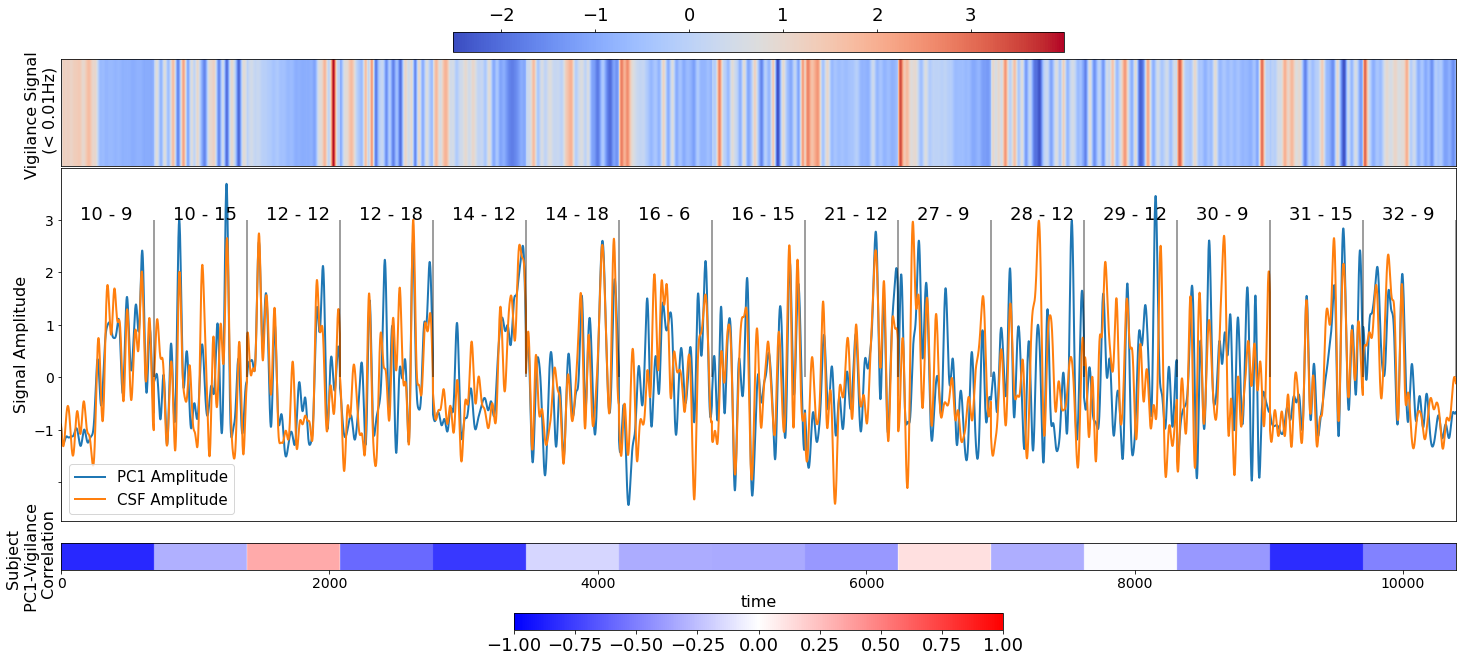

In [175]:
fig = plt.figure(figsize=(25,11), constrained_layout=False)
gspec = fig.add_gridspec(3,1, hspace=0, height_ratios=[0.25, 0.65, 0.2])
ax = fig.add_subplot(gspec[0])
im1 = ax.imshow(df_group['vigilance_ad_low'].values[np.newaxis,:], label='Vigilance', cmap='coolwarm', aspect=800)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Vigilance Signal \n (< 0.01Hz)', fontsize=16)
cbar = plt.colorbar(im1, ax=ax, orientation='horizontal', location='top', aspect=30)
cbar.ax.tick_params(labelsize=18)


ax = fig.add_subplot(gspec[1])
df_group['PC1_AMP'].plot(ax=ax, linewidth=2, label='PC1 Amplitude')
df_group['CSF_AMP'].plot(ax=ax, linewidth=2, label='CSF Amplitude')
ax.set_xlim([0, df_group.shape[0]])
ax.set_xticks([])
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.setp(ax.get_yticklabels()[1], visible=False)


n = 0
for i, (subj, scan) in enumerate((zip(subject_list_chang.subject, subject_list_chang.scan))):
    n += 693
    ax.vlines(n, 0, 3, color='black', alpha=0.5)
    ax.text(n-550, 3, f'{subj} - {scan}', fontsize=18)
    
ax.legend(fontsize=15, loc='lower left')

ax = fig.add_subplot(gspec[2])
im2 = ax.imshow(df_group['corr_vigilance_PC1'].values[np.newaxis,:], label='Subject PC1-Vigilance Correlation', 
          cmap='bwr', aspect=200, vmin=-1, vmax=1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('Subject \n PC1-Vigilance \n Correlation', fontsize=16)
ax.set_yticks([])
cbar = plt.colorbar(im2, ax=ax, orientation='horizontal', location='bottom', aspect=30, pad=0.4)
cbar.ax.tick_params(labelsize=18)

plt.show()

In [37]:
df_group[['RESP_AMP_HILBERT_AMP', 'PC1_AMP', 'CSF_AMP', 'vigilance_at_low']].corr()

,RESP_AMP_HILBERT_AMP,PC1_AMP,CSF_AMP,vigilance_at_low
RESP_AMP_HILBERT_AMP,1.000000,0.488756,0.392585,-0.103690
PC1_AMP,0.488756,1.000000,0.680102,-0.354907
CSF_AMP,0.392585,0.680102,1.000000,-0.363133
vigilance_at_low,-0.103690,-0.354907,-0.363133,1.000000


## 7.2 Vigilance and Respiration Interaction Analysis

### 7.2.1 Load Data (Chang)

In [83]:
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    # Create lag spline regressors
    lag_vec = np.arange(11)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_RVT_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)

    # Trim NaNs introduced by lag splines
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model = pd.concat([df_model_rv, df_model_pc1], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['scan'] = scan
    df_model['pc1'] = df['pc1'].loc[na_indx].values
    df_model['vigilance_at'] = df['vigilance_at_low'].loc[na_indx].values
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 7.2.2 Fit Model

In [40]:
full_pred = df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']]
test = [full_pred.iloc[:,i].values*df_model_group['vigilance_at'].values for i in range(full_pred.shape[1])]
test_df = pd.DataFrame(test, index=[f'{col}_i' for col in full_pred.columns]).T

full_pred_i = pd.concat([full_pred, test_df], axis=1)
full_pred_i['vigilance'] = df_model_group['vigilance_at'].values

pc_norm = zscore(df_model_group['pc1'])

va = sm.cov_struct.Autoregressive()
sm_fit_i = sm.GEE(pc_norm, full_pred_i, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_i.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                10245
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 683
                      Estimating Equations   Max. cluster size:                1366
Family:                           Gaussian   Mean cluster size:               931.4
Dependence structure:       Autoregressive   Num. iterations:                    34
Date:                     Thu, 11 Aug 2022   Scale:                           0.844
Covariance type:                    robust   Time:                         05:38:46
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RV_Knot_0       0.0651      0.057      1.138      0.255      -0.047       0.177
RV_Knot_1      -0.3819      0.045     -8.550      0.000      -0.469      -0.294
RV_Knot_2       0.0315      0.037      0.851      0.395      -0.041       0.104
RV_Knot_0_i    -0.0154      0.036     -0.430      0.667      -0.086       0.055
RV_Knot_1_i     0.1197      0.020      5.865      0.000       0.080       0.160
RV_Knot_2_i    -0.0162      0.014     -1.174      0.240      -0.043       0.011
vigilance       0.0080      0.006      1.419      0.156      -0.003       0.019
==============================================================================
Skew:                         -0.1974   Kurtosis:                       0.9853
Centered skew:                -0.1961   Centered kurtosis:              0.9820
==============================================================================
"""

### 7.2.3 Plot Interaction Results

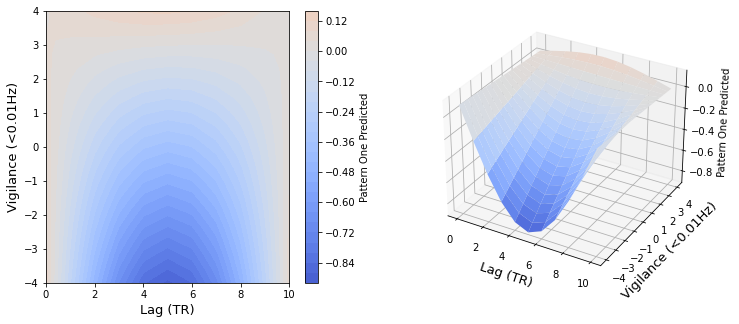

In [41]:
vigilance_eval = np.linspace(-4,4,20)
var_eval = 1 # 1 std above mean
rv_grid = []
rv_grid_conf = []
for v in vigilance_eval:
    pred_list = [var_eval * lag_spline.iloc[:, l].values for l in range(lag_spline.shape[1])]
    pred_mat = np.vstack(pred_list).T
    pred_mat_i = np.vstack([pred_mat[:,i]*v for i in range(full_pred.shape[1])]).T

    pred_mat_full = np.hstack([pred_mat, pred_mat_i, np.repeat(v,11)[:, np.newaxis]])

    # Get predictions from model
    pred_lags = sm_fit_i.predict(pred_mat_full)
    pred_obj = sm_fit_i.get_prediction(pred_mat_full)
    rv_grid.append(pred_lags)
    rv_grid_conf.append(pred_obj.summary_frame(alpha=0.05))

rv_grid = np.array(rv_grid)

fig = plt.figure(figsize=(12,5))
lags = np.arange(11)
x_mesh = np.meshgrid(lags, vigilance_eval)
# First subplot
ax = fig.add_subplot(1, 2, 1)
im = ax.contourf(x_mesh[0], x_mesh[1], rv_grid, 30, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
plt.colorbar(im, label='Pattern One Predicted')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x_mesh[0], x_mesh[1], rv_grid, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
ax.set_zlabel('Pattern One Predicted')
plt.show()

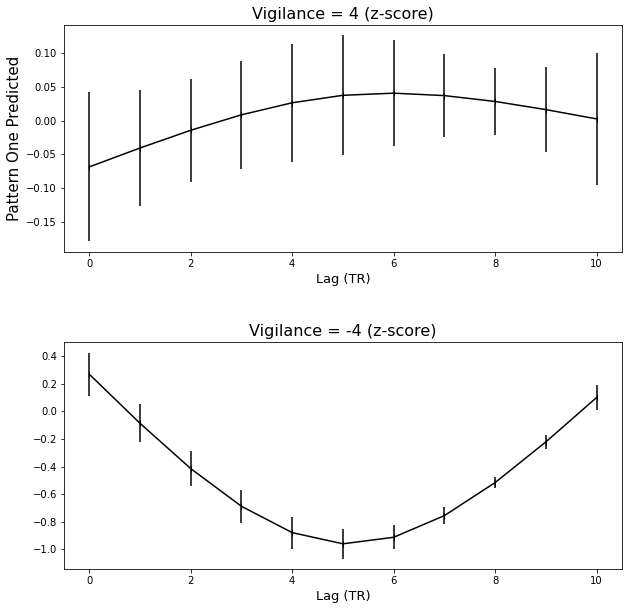

In [157]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.4)
lags = np.arange(11)
# First subplot
ax = fig.add_subplot(2, 1, 1)
ax.plot(lags, rv_grid_conf[-1]['mean'], color='black')
ax.errorbar(lags, rv_grid_conf[-1]['mean'], yerr=rv_grid_conf[-1]['mean_se'], fmt='|', color='black')
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_ylabel('Pattern One Predicted', fontsize=15)
ax.set_title('Vigilance = 4 (z-score)', fontsize=16)

# Second subplot
ax = fig.add_subplot(2, 1, 2)
ax.plot(lags, rv_grid_conf[0]['mean'], color='black')
ax.errorbar(lags, rv_grid_conf[0]['mean'], yerr=rv_grid_conf[0]['mean_se'], fmt='|', color='black')
ax.set_xlabel('Lag (TR)', fontsize=13)
ax.set_title('Vigilance = -4 (z-score)', fontsize=16)
plt.show()



# 8. Figure 4 - Multi-Component Physiological Response to Respiration Amplitude

## 8.1 Regression Commonality Analysis

### 8.1.1 Chang Dataset

#### 8.1.1.1 Run Commonality Analysis

In [44]:
# Regression (Spline) Parameters
lag_vec = np.arange(11)
nknots=3
n_bootstraps=100

# Initilialize results objects
cv_corr_r = []
full_r2_g = []
full_r2_g_e = []
common_r2_g = []
common_r2_g_e = []
unique_r2_g = {
    'RV': [],
    'PPG': [],
    'Infraslow': [],
    'Alpha': []
}
unique_r2_g_e = {
    'RV': [],
    'PPG': [],
    'Infraslow': [],
    'Alpha': []
}

lag_var_g = {
    'RV': [],
    'PPG': [],
    'Infraslow': [],
    'Alpha': []
}

# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    # Create lag spline bases for physio time series
    rv_basis, lag_spline = lag_basis(df['RESP_RVT_NK'], lag_vec, nknots)
    ppg_basis, _ = lag_basis(df['PPG_RATE_NK'], lag_vec, nknots)
    infraslow_basis, _ = lag_basis(df['Infraslow'], lag_vec, nknots)
    alpha_basis, _ = lag_basis(df['Alpha'], lag_vec, nknots)
    # Drop NaNs at beginning of time series introduced by lag, and then normalize
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    rv_basis_norm = zscore(rv_basis[na_indx, :], axis=0)
    infraslow_basis_norm = zscore(infraslow_basis[na_indx,:], axis=0)
    alpha_basis_norm = zscore(alpha_basis[na_indx,:], axis=0)
    ppg_basis_norm = zscore(ppg_basis[na_indx,:], axis=0)
    pred_list = [rv_basis_norm, ppg_basis_norm, infraslow_basis_norm, alpha_basis_norm]
    # Create full design matrix
    full_basis_norm = np.hstack(pred_list)
    
    # Get PC time course
    pc_norm = zscore(df['pc1'].loc[na_indx].values)

    # Run commonality analysis
    pred_label = ['RV', 'PPG', 'Infraslow', 'Alpha']
    pred_label_col_indx = np.repeat(np.arange(len(pred_label)), nknots)
    full_r2, common_r2, unique_r2 = commonality_analysis(pc_norm, full_basis_norm, pred_label, pred_label_col_indx)
    ## get bootstrapped confidence intervals
    full_r2_bootstrap = []
    common_r2_bootstrap = []
    unique_r2_bootstrap = []
    X = np.hstack([pc_norm[:,np.newaxis], full_basis_norm])
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        full_r2_b, common_r2_b, unique_r2_b = commonality_analysis(
            X_b[:,0], X_b[:,1:], pred_label, pred_label_col_indx)
        full_r2_bootstrap.append(full_r2_b)
        common_r2_bootstrap.append(common_r2_b)
        unique_r2_bootstrap.append(unique_r2_b)
    
    
    # Run cross-validation
    lin_reg = LinearRegression(fit_intercept=False)
    cv_corr = timeseries_cv(lin_reg, full_basis_norm, pc_norm, 
                            n_splits=5, gap=10, max_train_size=200, test_size=50)
    cv_corr_r.append(cv_corr)
    
    lag_dict = {}
    for label, pred in zip(pred_label, pred_list):
        lin_reg = LinearRegression(fit_intercept=False)
        lin_reg.fit(pred, pc_norm)
        pred_ts_lin = lin_reg.predict(pred)
        pred_lag_vec = np.linspace(0, 11, 40)
        lag_pred = evaluate_model(pred_lag_vec, lin_reg, lag_spline, 1)
        lag_dict[label] = [pred_lag_vec, lag_pred]
        
    # Append results
    full_r2_g.append(full_r2)
    full_r2_g_e.append(np.std(full_r2_bootstrap))
    common_r2_g.append(common_r2)
    common_r2_g_e.append(np.std(common_r2_bootstrap))
    subj_unique_r2 = pd.DataFrame(unique_r2_bootstrap).std(axis=0).to_dict()
    for label in pred_label:
        unique_r2_g[label].append(unique_r2[label])
        unique_r2_g_e[label].append(subj_unique_r2[label])
        lag_indx = np.argmax(np.abs(lag_dict[label][1]))
        var_lag = lag_dict[label][0][lag_indx]
        lag_var_g[label].append(var_lag)


#### 8.1.1.2 Plot Results

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


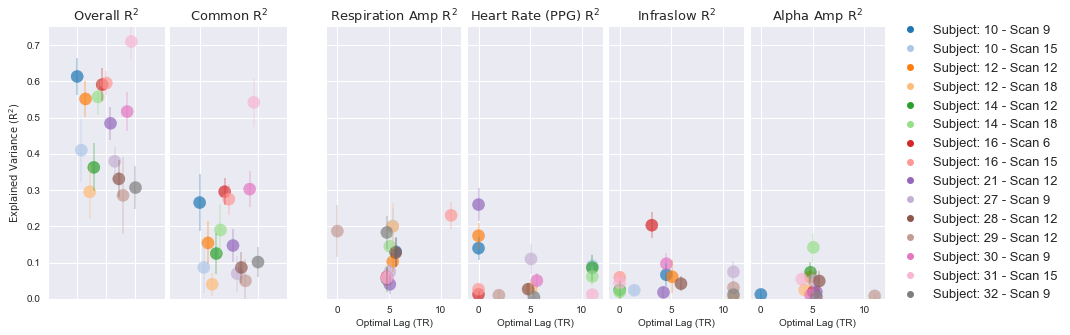

In [43]:
cmap = cm.get_cmap('tab20')
x_lag_vec = pred_lag_vec.copy()
subj_labels = [f'Subject: {subj} - Scan {scan}' for subj, scan in 
               zip(subject_list_chang.iloc[:, 0], subject_list_chang.iloc[:, 1])]
c_subj = [cmap(i) for i in range(len(subj_labels))]


with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,2, wspace=0.1, width_ratios=[0.3, 0.7])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gspec[0], wspace=0.05)
    g_sub2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gspec[1], wspace=0.05)

    ax = fig.add_subplot(g_sub1[0])
    ax.scatter(np.linspace(0,2,len(full_r2_g)), full_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(full_r2_g)), full_r2_g, 
                yerr=full_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
    ax.xaxis.set_ticklabels([])
    ax.set_title('Overall $R^2$', fontweight='bold', fontsize=13)
    ax.set_ylabel('Explained Variance ($R^2$)', fontsize=10)

    ax = fig.add_subplot(g_sub1[1])
    ax.scatter(np.linspace(0,2,len(common_r2_g)), common_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(common_r2_g)), common_r2_g, 
                yerr=common_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    ax.set_title('Common $R^2$', fontweight='bold', fontsize=13)

    ax = fig.add_subplot(g_sub2[0])
    ax.scatter(lag_var_g['RV'], unique_r2_g['RV'], s=150, alpha=0.7,
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['RV'], unique_r2_g['RV'], 
                yerr=unique_r2_g_e['RV'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Respiration Amp $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[1])
    ax.scatter(lag_var_g['PPG'], unique_r2_g['PPG'], s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['PPG'], unique_r2_g['PPG'], 
                yerr=unique_r2_g_e['PPG'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Heart Rate (PPG) $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[2])
    ax.scatter(lag_var_g['Infraslow'], unique_r2_g['Infraslow'], s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['Infraslow'], unique_r2_g['Infraslow'], 
                yerr=unique_r2_g_e['Infraslow'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Infraslow $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[3])
    scatter = ax.scatter(lag_var_g['Alpha'], unique_r2_g['Alpha'], s=150, alpha=0.7, 
                         c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['Alpha'], unique_r2_g['Alpha'], 
                yerr=unique_r2_g_e['Alpha'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.75])
    ax.set_xlim([-1,12])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Alpha Amp $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    recs = []
    for i in range(0,len(c_subj)):
        recs.append(Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=c_subj[i]))
    plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

    plt.show()

### 8.1.2 HCP Dataset

#### 8.1.2.1 Run Commonality Analysis

In [190]:
# Regression (Spline) Parameters
lag_vec = np.arange(31)
nknots=3
n_bootstraps=100

# Initilialize results objects
cv_corr_r = []
full_r2_g = []
full_r2_g_e = []
common_r2_g = []
common_r2_g_e = []
unique_r2_g = {
    'RV': [],
    'PPG': []
}
unique_r2_g_e = {
    'RV': [],
    'PPG': []
}

lag_var_g = {
    'RV': [],
    'PPG': []
}

# Loop through subjects and run regression
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],fs_hcp, norm=True)
    # Create lag spline bases for physio time series
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, _ = lag_basis(df['PPG_HR_NK'], lag_vec, nknots)
    # Drop NaNs at beginning of time series introduced by lag, and then normalize
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    rv_basis_norm = zscore(rv_basis[na_indx, :], axis=0)
    ppg_basis_norm = zscore(ppg_basis[na_indx,:], axis=0)
    pred_list = [rv_basis_norm, ppg_basis_norm]
    # Create full design matrix
    full_basis_norm = np.hstack(pred_list)
    
    # Get PC time course
    pc_norm = zscore(df['pc1'].loc[na_indx].values)

    # Run commonality analysis
    pred_label = ['RV', 'PPG']
    pred_label_col_indx = np.repeat(np.arange(len(pred_label)), nknots)
    full_r2, common_r2, unique_r2 = commonality_analysis(pc_norm, full_basis_norm, pred_label, pred_label_col_indx)
    ## get bootstrapped confidence intervals
    full_r2_bootstrap = []
    common_r2_bootstrap = []
    unique_r2_bootstrap = []
    X = np.hstack([pc_norm[:,np.newaxis], full_basis_norm])
    for n in range(n_bootstraps):
        # sampling from geometric distribution - 
        # p parameter determines block length (expected len = 1/p)
        X_b, _, _ = ts_resample(X, 0.05)
        full_r2_b, common_r2_b, unique_r2_b = commonality_analysis(
            X_b[:,0], X_b[:,1:], pred_label, pred_label_col_indx)
        full_r2_bootstrap.append(full_r2_b)
        common_r2_bootstrap.append(common_r2_b)
        unique_r2_bootstrap.append(unique_r2_b)
    
    # Run cross-validation
    lin_reg = LinearRegression(fit_intercept=False)
    cv_corr = timeseries_cv(lin_reg, full_basis_norm, pc_norm, 
                            n_splits=5, gap=20, max_train_size=400, test_size=100)
    cv_corr_r.append(cv_corr)
    
    lag_dict = {}
    for label, pred in zip(pred_label, pred_list):
        lin_reg = LinearRegression(fit_intercept=False)
        lin_reg.fit(pred, pc_norm)
        pred_ts_lin = lin_reg.predict(pred)
        pred_lag_vec = np.linspace(0, 31, 60)
        lag_pred = evaluate_model(pred_lag_vec, lin_reg, lag_spline, 1)
        lag_dict[label] = [pred_lag_vec, lag_pred]
        
    # Append results
    full_r2_g.append(full_r2)
    full_r2_g_e.append(np.std(full_r2_bootstrap))
    common_r2_g.append(common_r2)
    common_r2_g_e.append(np.std(common_r2_bootstrap))
    subj_unique_r2 = pd.DataFrame(unique_r2_bootstrap).std(axis=0).to_dict()
    for label in pred_label:
        unique_r2_g[label].append(unique_r2[label])
        unique_r2_g_e[label].append(subj_unique_r2[label])
        lag_indx = np.argmax(np.abs(lag_dict[label][1]))
        var_lag = lag_dict[label][0][lag_indx]
        lag_var_g[label].append(var_lag)


#### 8.1.2.2 Plot Results

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


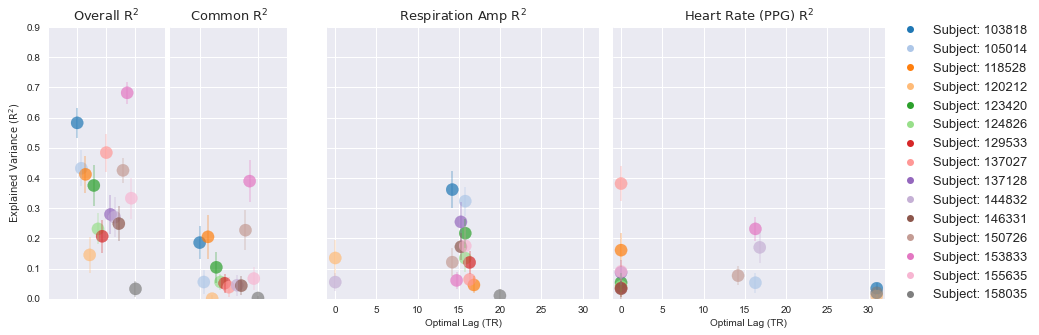

In [305]:
cmap = cm.get_cmap('tab20')
x_lag_vec = pred_lag_vec.copy()
subj_labels = [f'Subject: {subj}' for subj in subject_list_hcp.iloc[:, 0]]
c_subj = [cmap(i) for i in range(len(subj_labels))]


with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,2, wspace=0.1, width_ratios=[0.3, 0.7])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gspec[0], wspace=0.05)
    g_sub2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gspec[1], wspace=0.05)


    ax = fig.add_subplot(g_sub1[0])
    ax.scatter(np.linspace(0,2,len(full_r2_g)), full_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(full_r2_g)), full_r2_g, 
                yerr=full_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='upper'))
    ax.xaxis.set_ticklabels([])
    ax.set_title('Overall $R^2$', fontweight='bold', fontsize=13)
    ax.set_ylabel('Explained Variance ($R^2$)', fontsize=10)

    ax = fig.add_subplot(g_sub1[1])
    ax.scatter(np.linspace(0,2,len(common_r2_g)), common_r2_g, s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(np.linspace(0,2,len(common_r2_g)), common_r2_g, 
                yerr=common_r2_g_e, fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,3])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    ax.set_title('Common $R^2$', fontweight='bold', fontsize=13)

    ax = fig.add_subplot(g_sub2[0])
    ax.scatter(lag_var_g['RV'], unique_r2_g['RV'], s=150, alpha=0.7,
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['RV'], unique_r2_g['RV'], 
                yerr=unique_r2_g_e['RV'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,32])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Respiration Amp $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    ax = fig.add_subplot(g_sub2[1])
    ax.scatter(lag_var_g['PPG'], unique_r2_g['PPG'], s=150, alpha=0.7, 
               c=c_subj, label=subj_labels)
    ax.errorbar(lag_var_g['PPG'], unique_r2_g['PPG'], 
                yerr=unique_r2_g_e['PPG'], fmt='|', alpha=0.3, ecolor=c_subj)
    ax.set_ylim([0,0.9])
    ax.set_xlim([-1,32])
    ax.grid(True)
    ax.yaxis.set_ticklabels([])
    ax.set_title('Heart Rate (PPG) $R^2$', fontweight='bold', fontsize=13)
    ax.set_xlabel('Optimal Lag (TR)', fontsize=10)

    recs = []
    for i in range(0,len(c_subj)):
        recs.append(Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=c_subj[i]))
    plt.legend(recs,subj_labels,loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

    plt.show()

## 8.2 Multi-Set Canonical Correlation Analysis

### 8.2.1 Chang Dataset

#### 8.2.1.1 Fit Model

In [45]:
df_model_group = []
df_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    
    # Create a separate dataframe for modeling w/ lag splines
    lag_vec = np.arange(11)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_RVT_NK'], lag_vec, nknots)
    alpha_basis, lag_spline = lag_basis(df['Alpha'], lag_vec, nknots)
    infraslow_basis, lag_spline = lag_basis(df['Infraslow'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_RATE_NK'], lag_vec, nknots)
    ppg_low_basis, lag_spline = lag_basis(df['PPG_LOW_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)
    csf_basis, lag_spline = lag_basis(df['csf'], lag_vec, nknots)

    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_ppg_low = pd.DataFrame(zscore(ppg_low_basis[na_indx, :]), 
                                    columns = [f'PPG_LOW_Knot_{i}' for i in range(nknots)])
    df_model_pc = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model_inf = pd.DataFrame(zscore(infraslow_basis[na_indx, :]), 
                               columns = [f'INF_Knot_{i}' for i in range(nknots)])
    df_model_alp = pd.DataFrame(zscore(alpha_basis[na_indx, :]), 
                               columns = [f'ALPHA_Knot_{i}' for i in range(nknots)])
    df_model_csf = pd.DataFrame(zscore(csf_basis[na_indx, :]), 
                               columns = [f'CSF_Knot_{i}' for i in range(nknots)])
    
    # Concatenate into one dataframe
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_ppg_low, df_model_pc, 
                          df_model_inf, df_model_alp, df_model_csf], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['sleep_flag'] = sleep
    df_model['scan'] = scan
    df_model_group.append(df_model)
    df_group.append(df.loc[na_indx, :].copy())

# Group-wise temporal concatenation
df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)
df_group = pd.concat(df_group, axis=0, ignore_index=True)

# Fit MCCA
mcca = MCCA(latent_dims=3)
mcca.fit([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])


MCCA(c=[0, 0, 0, 0, 0, 0, 0], latent_dims=3,
     random_state=RandomState(MT19937) at 0x7FEE59CBF740)

#### 5.2.1.2 Average Pairwise Correlation

In [46]:
mcca.score([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

array([0.26131573, 0.25282582, 0.11137376])

#### 5.2.1.3 Pairwise Correlation Matrix

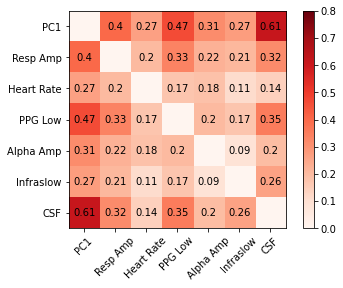

In [47]:
corr_mat = mcca.correlations([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=['PC1', 'Resp AMP', 'HR', 'PPG Low', 'Alpha', 'Infraslow', 'CSF'], 
                        index=['PC1', 'Resp AMP', 'HR', 'PPG Low', 'Alpha', 'Infraslow', 'HR'])
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots()
im = ax.imshow(corr_mat_array, vmin=0, vmax=0.8, cmap='Reds')
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(['PC1', 'Resp Amp', 'Heart Rate', 'PPG Low', 'Alpha Amp', 'Infraslow', 'CSF'], rotation=45)
ax.set_yticklabels(['PC1', 'Resp Amp', 'Heart Rate', 'PPG Low', 'Alpha Amp', 'Infraslow', 'CSF'])

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center')
plt.colorbar(im, ax=ax)

#### 5.2.1.4 Physio - Canonical Variate Cross-Correlations

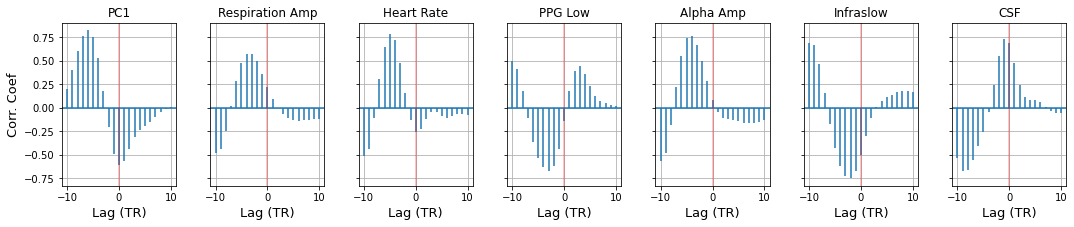

In [48]:
cca_pred = mcca.transform([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

cca_pred_df = pd.DataFrame(
    np.vstack([cca_pred[i][:,0] for i in range(7)]).T,
    columns = ['PC1', 'Respiration Amp', 'Heart Rate', 'PPG Low', 'Alpha Amp', 'Infraslow', 'CSF']
)


fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(18,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.3)

data_cols = ['pc1', 'RESP_AMP_HILBERT', 'PPG_RATE_NK', 'PPG_LOW_NK', 'Alpha', 'Infraslow', 'csf']
cca_cols = ['PC1', 'Respiration Amp', 'Heart Rate', 'PPG Low', 'Alpha Amp', 'Infraslow', 'CSF']
for i, (ax, d_col, c_col) in enumerate(zip(axs, data_cols, cca_cols)):
    ax.xcorr(df_group[d_col], cca_pred_df[c_col], maxlags=10)
    ax.set_xlabel('Lag (TR)', fontsize=13)
    ax.set_title(c_col, fontsize=12)
    ax.axvline(0, 0, 1, alpha=0.3, color='red')
    if i == 0:
        ax.set_ylabel('Corr. Coef', fontsize=13)
    ax.grid(True)
    

### 5.2.2. HCP Dataset

#### 5.2.2.1 Fit Model

In [49]:
df_model_group = []
df_group = []
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'], fs_hcp, norm=True)
    
    # Create a separate dataframe for modeling w/ lag splines
    lag_vec = np.arange(31)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_RVT_NK'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_HR_NK'], lag_vec, nknots)
    ppg_low_basis, lag_spline = lag_basis(df['PPG_LOW_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)
    csf_basis, lag_spline = lag_basis(df['csf'], lag_vec, nknots)

    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model_ppg_low = pd.DataFrame(zscore(ppg_low_basis[na_indx, :]), 
                                    columns = [f'PPG_LOW_Knot_{i}' for i in range(nknots)])
    df_model_csf = pd.DataFrame(zscore(csf_basis[na_indx, :]), 
                               columns = [f'CSF_Knot_{i}' for i in range(nknots)])
    # Concatenate into one dataframe
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_ppg_low, 
                          df_model_pc1, df_model_csf], axis=1)

    # supply meta-information
    df_model['subj'] = subj
    
    df_model_group.append(df_model)
    df_group.append(df.loc[na_indx, :].copy())

# Group-wise temporal concatenation
df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)
df_group = pd.concat(df_group, axis=0, ignore_index=True)

# Fit MCCA
mcca = MCCA(latent_dims=3)
mcca.fit([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

MCCA(c=[0, 0, 0, 0, 0], latent_dims=3,
     random_state=RandomState(MT19937) at 0x7FEE59CBF740)

#### 5.2.2.2 Average Pairwise Correlation

In [50]:
mcca.score([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

array([0.28839732, 0.2518405 , 0.13267222])

#### 5.2.2.3. Pairwise Correlation Matrix

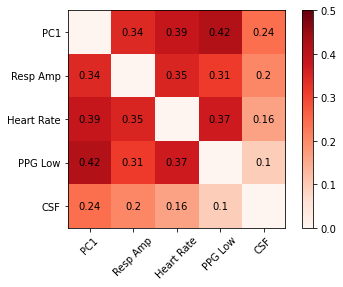

In [51]:
corr_mat = mcca.correlations([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=['PC1', 'Resp AMP', 'HR', 'PPG Low', 'CSF'], 
                        index=['PC1', 'Resp AMP', 'HR', 'PPG Low', 'HR'])
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots()
im = ax.imshow(corr_mat_array, vmin=0, vmax=0.5, cmap='Reds')
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(['PC1', 'Resp Amp', 'Heart Rate', 'PPG Low', 'CSF'], rotation=45)
ax.set_yticklabels(['PC1', 'Resp Amp', 'Heart Rate', 'PPG Low', 'CSF'])

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center')
plt.colorbar(im, ax=ax)

#### 5.2.2.4 Physio-Canonical Variate Cross-Correlations 

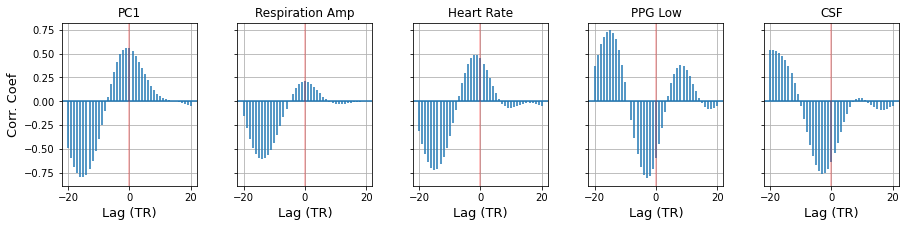

In [52]:
cca_pred = mcca.transform([
    df_model_group[['PC_Knot_0', 'PC_Knot_1', 'PC_Knot_2']],
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['PPG_LOW_Knot_0', 'PPG_LOW_Knot_1', 'PPG_LOW_Knot_2']],
    df_model_group[['CSF_Knot_0', 'CSF_Knot_1', 'CSF_Knot_2']]
])

cca_pred_df = pd.DataFrame(
    np.vstack([cca_pred[i][:,0] for i in range(5)]).T,
    columns = ['PC1', 'Respiration Amp', 'Heart Rate', 'PPG Low', 'CSF']
)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.3)

data_cols = ['pc1', 'RESP_AMP_HILBERT', 'PPG_HR_NK', 'PPG_LOW_NK', 'csf']
cca_cols = ['PC1', 'Respiration Amp', 'Heart Rate', 'PPG Low', 'CSF']
for i, (ax, d_col, c_col) in enumerate(zip(axs, data_cols, cca_cols)):
    ax.xcorr(df_group[d_col], cca_pred_df[c_col], maxlags=20)
    ax.set_xlabel('Lag (TR)', fontsize=13)
    ax.set_title(c_col, fontsize=12)
    ax.axvline(0, 0, 1, alpha=0.3, color='red')
    if i == 0:
        ax.set_ylabel('Corr. Coef', fontsize=13)
    ax.grid(True)

## 5.3 Chang Breathing Dataset

### 5.3.1 Create Breath Onset Blocks

In [22]:
bh_events = load_chang_bh_event_file()
bh_event_blocks = construct_deep_breath_blocks(bh_events, 2.1)
bh_event_blocks = [tuple(b) for b in bh_event_blocks]
breath_onsets_tr = [block[0] for block in bh_event_blocks]

### 5.3.2 Load Trial-Level Compliance CSV

In [23]:
compliance = pd.read_csv('data/dataset_chang_bh/compliance.csv')
compliance = compliance.set_index(
    compliance['subject'].astype(str) + '_' + compliance['scan'].astype(str)
)
trial_cols = [f'trial{n+1}' for n in range(9)]

### 5.3.3. Physio Average to Deep Breath Onset

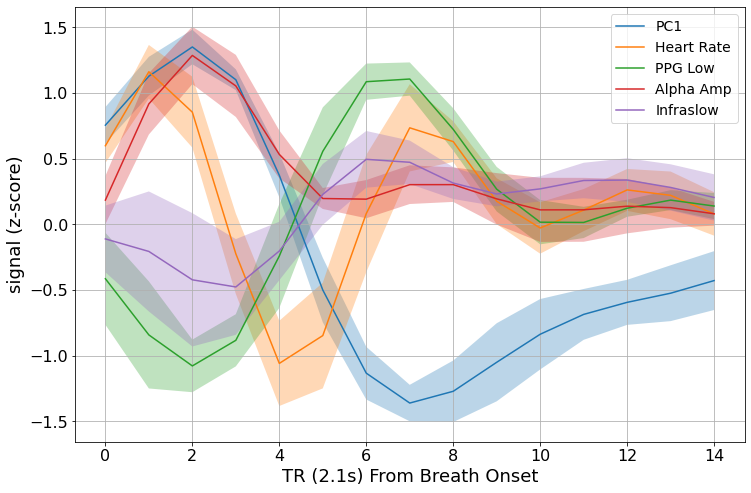

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
signal_cols = ['pc1', 'PPG_RATE_NK', 'PPG_LOW_NK', 'Alpha', 'Infraslow']
signal_labels = ['PC1', 'Heart Rate', 'PPG Low', 'Alpha Amp', 'Infraslow']
subj_scan_dict = {
    15: [9, 15],
    17: [6, 15],
    19: [16, 22],
    20: [12],
    21: [9],
    25: [12]
}

signals_avg = []
for subj in subj_scan_dict:
    signal_blocks = []
    for scan in subj_scan_dict[subj]: 
        if scan < 10:
            scan_str = f'000{scan}'
        else:
            scan_str = f'00{scan}'
        df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang_bh[f'{subj}_{scan}'], 
                                     pc_p_subj_chang_bh[f'{subj}_{scan}'], fs_chang)
        scan_compliance = compliance.loc[f'{subj}_{scan}'][trial_cols].values
        scan_event_blocks = [block for block, c in zip(bh_event_blocks, scan_compliance) if c == 1]
        signal_ts = df_subj[signal_cols].values
        signal_blocks.append(np.squeeze(signal_ts[scan_event_blocks, :]))
        
    signal_blocks = np.concatenate(signal_blocks, axis=0) 
    signals_avg.append(signal_blocks.mean(axis=0))

signals_avg_group = np.mean(signals_avg, axis=0)
signals_se_group = np.std(signals_avg, axis=0) / np.sqrt(len(signals_avg))


for i, signal in enumerate(signal_labels):
    ax.plot(np.arange(15), signals_avg_group[:,i], label=signal)
    ax.fill_between(np.arange(15), signals_avg_group[:,i]-signals_se_group[:,i], 
                    signals_avg_group[:,i]+signals_se_group[:,i], alpha=0.3)


ax.legend(fontsize=14)
ax.grid(True)
ax.set_xlabel('TR (2.1s) From Breath Onset', fontsize=18)
ax.set_ylabel('signal (z-score)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

# 7. Supplementary Figure 4 - PCA Results Across Datasets 

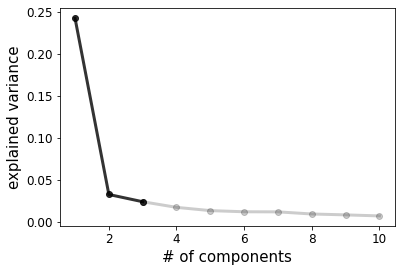

In [260]:
pca_results = [
    'results/pca/chang_pca_group_results.pkl',
    'results/pca/chang_bh_pca_group_results.pkl',
    'results/pca/hcp_fix_pca_group_results.pkl',
    'results/pca/nki_pca_group_results.pkl',
    'results/pca/monash_pca_group_results.pkl'
]

exp_var_all = []
for res in pca_results:
    res_tmp = pickle.load(open(res, 'rb'))
    exp_var_all.append(res_tmp['exp_var'])

fig, ax = plt.subplots()
e = exp_var_all[4]
ax.plot(np.arange(1, 4), e[:3], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(3, 11), e[2:11], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



# 8. Supplementary Figure 6 - CAP Analysis

## 8.1 Chang Dataset

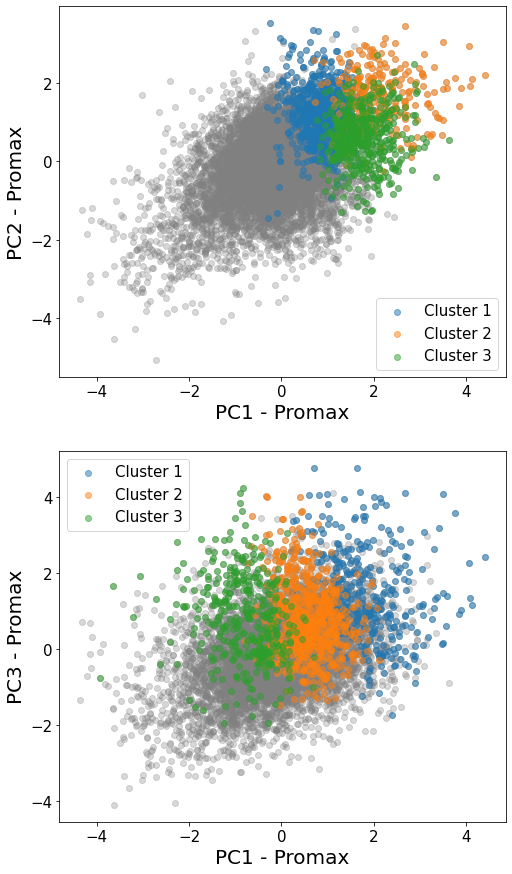

In [401]:
pca_res = pickle.load(open('results/pca/chang_pca_group_promax_results.pkl', 'rb'))
pca_res['pc_scores'][:,2] = pca_res['pc_scores'][:,2]*-1


cap_res_lag0 = pickle.load(open('results/caps/chang_cap_global_sig_pos_t1_lag0_results.pkl', 'rb'))
cap_res_lag2 = pickle.load(open('results/caps/chang_cap_global_sig_pos_t1_lag2_results.pkl', 'rb'))

supra_thres_tp_lag0 = []
supra_thres_tp_lag2 = []
n_t = 0
for cap_lag0_subj, cap_lag2_subj in zip(cap_res_lag0['supra_thres_tps'], cap_res_lag2['supra_thres_tps']):
    supra_thres_tp_lag0.append(cap_lag0_subj+n_t)
    supra_thres_tp_lag2.append(cap_lag2_subj+n_t)
    n_t += 693
supra_thres_tp_lag0 = np.concatenate(supra_thres_tp_lag0).ravel()
supra_thres_tp_lag2 = np.concatenate(supra_thres_tp_lag2).ravel()

fig, axs = plt.subplots(2,1,figsize=(8,15))
p1 = axs[0].scatter(pca_res['pc_scores'][:,0], pca_res['pc_scores'][:,1], 
                    color='gray', alpha=0.3)
p2 = axs[1].scatter(pca_res['pc_scores'][:,0], pca_res['pc_scores'][:,2], 
                    color='gray', alpha=0.3)

clus_indx_lag0 = cap_res_lag0['c_indx']
clus_indx_lag2 = cap_res_lag2['c_indx']

clus_lag0_labels = np.sort(np.unique(clus_indx_lag0))
clus_lag2_labels = np.sort(np.unique(clus_indx_lag2))

cmap = plt.cm.get_cmap('tab10')
for i, (clus_lag0, clus_lag2) in enumerate(zip(clus_lag0_labels, clus_lag2_labels)):
    c_l0_i = np.where(clus_indx_lag0 == clus_lag0)
    c_l2_i = np.where(clus_indx_lag2 == clus_lag2)
    supra_thres_tp_lag0_c = supra_thres_tp_lag0[c_l0_i]
    supra_thres_tp_lag2_c = supra_thres_tp_lag2[c_l2_i]
    axs[0].scatter(pca_res['pc_scores'][supra_thres_tp_lag0_c,0], 
                   pca_res['pc_scores'][supra_thres_tp_lag0_c,1], 
                   color=cmap(i), alpha=0.5, label=f'Cluster {i+1}')
    axs[1].scatter(pca_res['pc_scores'][supra_thres_tp_lag2_c,0], 
                   pca_res['pc_scores'][supra_thres_tp_lag2_c,2], 
                   color=cmap(i), alpha=0.5, label=f'Cluster {i+1}')

axs[0].set_xlabel('PC1 - Promax', fontsize=20)
axs[0].set_ylabel('PC2 - Promax', fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].legend(fontsize=15)

axs[1].set_xlabel('PC1 - Promax', fontsize=20)
axs[1].set_ylabel('PC3 - Promax', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=15)
axs[1].legend(fontsize=15)

# 9. Group Regression Analysis

## 9.1 Chang Dataset

### 9.1.1 Load Data for Regression Analysis

In [30]:
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'], 
                         fs_chang)
    # Create lag spline regressors
    lag_vec = np.arange(11)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    alpha_basis, lag_spline = lag_basis(df['Alpha'], lag_vec, nknots)
    infraslow_basis, lag_spline = lag_basis(df['Infraslow'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_RATE_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)
    

    # Trim NaNs introduced by lag splines
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_inf = pd.DataFrame(zscore(infraslow_basis[na_indx, :]), 
                               columns = [f'INF_Knot_{i}' for i in range(nknots)])
    df_model_alp = pd.DataFrame(zscore(alpha_basis[na_indx, :]), 
                               columns = [f'ALPHA_Knot_{i}' for i in range(nknots)])
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1, 
                          df_model_inf, df_model_alp, df_model_delta, 
                          df_model_theta], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['sleep_flag'] = sleep
    df_model['scan'] = scan
    df_model['pc1'] = df['pc1'].loc[na_indx].values
    df_model['pc2'] = df['pc2'].loc[na_indx].values
    df_model['pc3'] = df['pc3'].loc[na_indx].values
    df_model['pc1_p'] = df['pc1_p'].loc[na_indx].values
    df_model['pc2_p'] = df['pc2_p'].loc[na_indx].values
    df_model['pc3_p'] = df['pc3_p'].loc[na_indx].values
    df_model['csf'] = df['csf'].loc[na_indx].values
    df_model['vigilance_at'] = df['vigilance_at_low'].loc[na_indx].values
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 9.1.2 Fit Full Group Regression Model

#### 9.1.2.1 Fit Model

In [31]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
    df_model_group[['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2']],
    df_model_group[['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']]
]
    
pred_label = ['RV', 'PPG', 'Infraslow', 'Alpha']
pc_norm = zscore(df_model_group['pc1'])

full_pred = pd.concat(pred_list, axis=1)

va = sm.cov_struct.Autoregressive()
sm_fit_full = sm.GEE(pc_norm, full_pred, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_full.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1293: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                10245
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 683
                      Estimating Equations   Max. cluster size:                1366
Family:                           Gaussian   Mean cluster size:               931.4
Dependence structure:       Autoregressive   Num. iterations:                    60
Date:                     Mon, 08 Aug 2022   Scale:                           0.695
Covariance type:                    robust   Time:                         22:06:05
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
RV_Knot_0        0.0667      0.038      1.769      0.077      -0.007       0.141
RV_Knot_1       -0.3687      0.029    -12.801      0.000      -0.425      -0.312
RV_Knot_2       -0.0165      0.032     -0.511      0.610      -0.080       0.047
PPG_Knot_0       0.2583      0.049      5.248      0.000       0.162       0.355
PPG_Knot_1      -0.1147      0.038     -2.980      0.003      -0.190      -0.039
PPG_Knot_2       0.0905      0.026      3.490      0.000       0.040       0.141
INF_Knot_0       0.1520      0.041      3.683      0.000       0.071       0.233
INF_Knot_1       0.0685      0.024      2.800      0.005       0.021       0.116
INF_Knot_2       0.0024      0.021      0.114      0.909      -0.039       0.044
ALPHA_Knot_0     0.0181      0.021      0.851      0.395      -0.024       0.060
ALPHA_Knot_1    -0.1675      0.034     -4.987      0.000      -0.233      -0.102
ALPHA_Knot_2     0.0382      0.023      1.671      0.095      -0.007       0.083
==============================================================================
Skew:                         -0.0485   Kurtosis:                       0.8144
Centered skew:                -0.0490   Centered kurtosis:              0.8141
==============================================================================
"""

#### 9.1.2.2 Plot Model Parameters

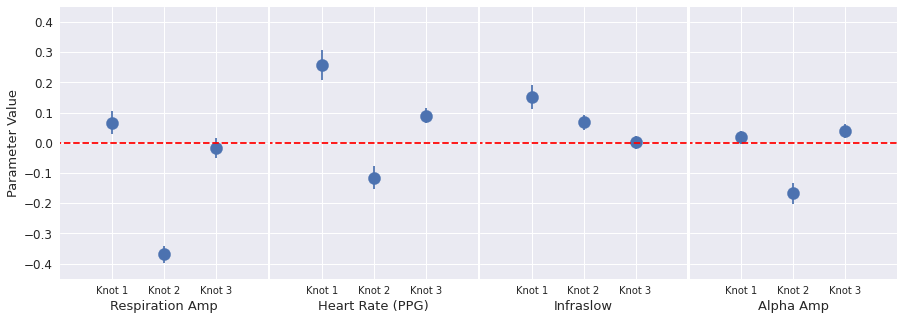

In [26]:
param_labels = [
    ['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2'],
    ['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2'],
    ['INF_Knot_0', 'INF_Knot_1', 'INF_Knot_2'],
    ['ALPHA_Knot_0', 'ALPHA_Knot_1', 'ALPHA_Knot_2']
]
label_group = ['Respiration Amp', 'Heart Rate (PPG)', 'Infraslow', 'Alpha Amp']
param_dict = sm_fit_full.params.to_dict()
se_dict = {l: se for l, se in zip(sm_fit_full.params.index, sm_fit_full.standard_errors())}
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,4, wspace=0.01)
    for i, (labels, g_label) in enumerate(zip(param_labels, label_group)):
        ax = fig.add_subplot(gspec[i])
        param_vec = [param_dict[l] for l in labels]
        se_vec = [se_dict[l] for l in labels]
        scatter = ax.scatter(np.arange(3), param_vec, s=150)
        ax.errorbar(np.arange(3), param_vec, yerr=se_vec, fmt='|')
        ax.set_xlabel(g_label, fontsize=13)
        ax.set_ylim([-0.45,0.45])
        ax.set_xlim([-1,3])
        ax.axhline(0,-1,4, linestyle='--', c='r',)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
        ax.xaxis.set_ticks([0,1,2])
        ax.set_xticklabels(['Knot 1' , 'Knot 2', 'Knot 3'])
        if i == 0:
            ax.tick_params(axis='y', labelsize=12)
            ax.set_ylabel('Parameter Value', fontsize=13)
        else:
            ax.yaxis.set_ticklabels([])
        ax.grid(True)

## 7.2 HCP Dataset

### 7.2.1 Load Data for Regression Analysis

In [170]:
df_model_group = []
for i in range(subject_list_hcp.shape[0]):
    # Load Subject
    subj = subject_list_hcp.iloc[i, 0]
    df = load_subj_hcp(subj, pc_subj_hcp[f'{subj}'], pc_v_subj_hcp[f'{subj}'], pc_p_subj_hcp[f'{subj}'],
               clus_subj_precuneus_hcp[f'{subj}'], clus_subj_superior_parietal_hcp[f'{subj}'], 
               fs_hcp, norm=True)
    
    # Create a separate dataframe for modeling w/ lag splines
    lag_vec = np.arange(31)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_AMP_HILBERT'], lag_vec, nknots)
    ppg_basis, lag_spline = lag_basis(df['PPG_LOW_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)

    # Trim NaNs introduced from lag splines and label columns
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_rv['RV'] = df['RESP_AMP_HILBERT'].loc[na_indx].values
    df_model_ppg = pd.DataFrame(zscore(ppg_basis[na_indx, :]), 
                               columns = [f'PPG_Knot_{i}' for i in range(nknots)])
    df_model_ppg['PPG'] = df['PPG_LOW_NK'].loc[na_indx].values
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    
    # Concatenate into one dataframe
    df_model = pd.concat([df_model_rv, df_model_ppg, df_model_pc1], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['pc1'] = df['pc1'].loc[na_indx].values
    df_model['pc2'] = df['pc2'].loc[na_indx].values
    df_model['pc1_p'] = df['pc1_p'].loc[na_indx].values
    df_model['pc2_p'] = df['pc2_p'].loc[na_indx].values
    df_model['pc3_p'] = df['pc3_p'].loc[na_indx].values
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 7.2.2 Fit Group Regression Model

#### 7.2.2.1 Fit Model

In [106]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']]
]
    
pred_label = ['RV', 'PPG']
pc_norm = zscore(df_model_group['pc1'])

full_pred = pd.concat(pred_list, axis=1)

va = sm.cov_struct.Autoregressive()
sm_fit_full = sm.GEE(pc_norm, full_pred, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_full.summary()

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1293: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                17550
Model:                                 GEE   No. clusters:                       15
Method:                        Generalized   Min. cluster size:                1170
                      Estimating Equations   Max. cluster size:                1170
Family:                           Gaussian   Mean cluster size:              1170.0
Dependence structure:       Autoregressive   Num. iterations:                    60
Date:                     Tue, 19 Apr 2022   Scale:                           0.680
Covariance type:                    robust   Time:                         16:44:31
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RV_Knot_0      0.1186      0.041      2.927      0.003       0.039       0.198
RV_Knot_1     -0.3676      0.048     -7.694      0.000      -0.461      -0.274
RV_Knot_2     -0.0287      0.030     -0.970      0.332      -0.087       0.029
PPG_Knot_0     0.3916      0.048      8.188      0.000       0.298       0.485
PPG_Knot_1    -0.1709      0.051     -3.361      0.001      -0.270      -0.071
PPG_Knot_2     0.1317      0.031      4.259      0.000       0.071       0.192
==============================================================================
Skew:                          0.0505   Kurtosis:                       0.9405
Centered skew:                 0.0459   Centered kurtosis:              0.9453
==============================================================================
"""

#### 7.2.2.2 Plot Model Parameters

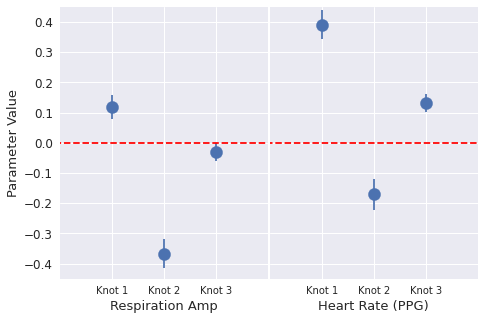

In [109]:
param_labels = [
    ['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2'],
    ['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2'],
]
label_group = ['Respiration Amp', 'Heart Rate (PPG)']
param_dict = sm_fit_full.params.to_dict()
se_dict = {l: se for l, se in zip(sm_fit_full.params.index, sm_fit_full.standard_errors())}
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), constrained_layout=False)
    gspec = fig.add_gridspec(1,4, wspace=0.01)
    for i, (labels, g_label) in enumerate(zip(param_labels, label_group)):
        ax = fig.add_subplot(gspec[i])
        param_vec = [param_dict[l] for l in labels]
        se_vec = [se_dict[l] for l in labels]
        scatter = ax.scatter(np.arange(3), param_vec, s=150)
        ax.errorbar(np.arange(3), param_vec, yerr=se_vec, fmt='|')
        ax.set_xlabel(g_label, fontsize=13)
        ax.set_ylim([-0.45,0.45])
        ax.set_xlim([-1,3])
        ax.axhline(0,-1,4, linestyle='--', c='r',)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
        ax.xaxis.set_ticks([0,1,2])
        ax.set_xticklabels(['Knot 1' , 'Knot 2', 'Knot 3'])
        if i == 0:
            ax.tick_params(axis='y', labelsize=12)
            ax.set_ylabel('Parameter Value', fontsize=13)
        else:
            ax.yaxis.set_ticklabels([])
        ax.grid(True)

### 7.2.2 Perform Commonality Analysis

In [173]:
pred_list = [
    df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']],
    df_model_group[['PPG_Knot_0', 'PPG_Knot_1', 'PPG_Knot_2']],
]
    
pred_label = ['RV', 'PPG']
pc_norm = zscore(df_model_group['pc3_p'])

full_pred = pd.concat(pred_list, axis=1)
sm_fit = sm.OLS(pc_norm, full_pred, hasconst=False).fit()
full_r2 = sm_fit.rsquared
common_r2 = full_r2.copy()
unique_r2 = {}
for i, label in enumerate(pred_label):
    partial_pred = pd.concat([pred for n, pred in enumerate(pred_list) if n != i], axis=1)
    sm_fit_partial = sm.OLS(pc_norm, partial_pred, hasconst=False).fit()
    unique_r2[label] = full_r2 - sm_fit_partial.rsquared
    common_r2 -= unique_r2[label]

print(f'Full R2: {full_r2}')
print(f'Unique R2: {unique_r2}')
print(f'Common R2: {common_r2}')

Full R2: 0.2819637145556626
Unique R2: {'RV': 0.21643773673797062, 'PPG': 0.016085010560668356}
Common R2: 0.04944096725702363


# 10. Misc

In [12]:
from utils.load_write import convert_2d
recon_promax = []
for i in range(2):
    nifti = nb.load(f'results/cpca/hcp_cpca_recon_n{i}_promax.nii', keep_file_open = True)
    mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz').get_fdata()
    nifti_data = nifti.get_fdata()
    nifti.uncache()
    nifti_data = convert_2d(mask, nifti_data)
    if i == 0:
        nifti_data*=-1
    recon_promax.append(nifti_data)
recon_promax = np.stack(recon_promax, axis=2)

In [135]:
weight_vec = [0.6,0.4]
for i in range(2):
    if i == 1:
        recon_promax[:,:,i] = np.roll(recon_promax[:,:,i], 6, 0)
    recon_promax[:,:,i] *= weight_vec[i]
recon_sum = recon_promax.sum(axis=2)

In [136]:
mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask_bin = mask.get_fdata() > 0
nifti_4d = np.zeros(mask.shape + (recon_sum.shape[0],), dtype=recon_sum.dtype)
nifti_4d[mask_bin, :] = recon_sum.T
nifti_out = nb.Nifti2Image(nifti_4d, mask.affine)
nb.save(nifti_out, 'recon_sum.nii')

In [137]:
cpca_ts = pickle.load(open('results/cpca/chang_pca_group_c_results.pkl', 'rb'))['pc_scores']
cpca_promax_ts = pickle.load(open('results/cpca/chang_pca_group_promax_c_results.pkl', 'rb'))['pc_scores']

In [138]:
cpca_ts_real = np.real(cpca_ts)
cpca_promax_ts_real = np.real(cpca_promax_ts)
cpca_promax_ts_real[:,0] *= -1

In [82]:
subj = 25
scan=12
df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
breath_onset_vec = np.zeros((df_subj.shape[0], 1))
breath_onset_vec[breath_onsets_tr] = 1
df_subj['breath_onset'] = breath_onset_vec

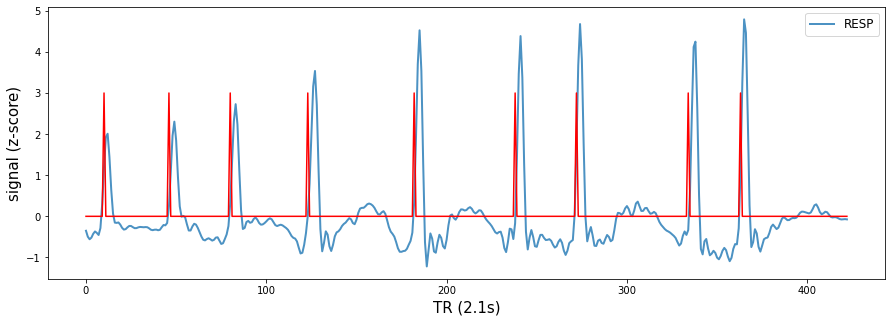

In [83]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(df_subj['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df_subj['RESP_AMP_HILBERT'] ,label='RESP', linewidth=2, alpha=0.8)
ax.plot(df_subj['breath_onset']*3, color='r')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

In [290]:
breath_onsets_vec = np.zeros((df_subj.shape[0], 1))
breath_onsets_vec[breath_onsets_tr] = 1

def shifted_onsets(breath_onsets_vec):
    rand_shift = np.random.randint(0, len(breath_onsets_vec))
    breath_onsets_vec_rand = np.roll(breath_onsets_vec, rand_shift)
    breath_onsets_rand_tr = np.where(breath_onsets_vec_rand==1)[0]
    return breath_onsets_rand_tr

signal_ts = df_subj['Alpha'].values[np.newaxis, :]
signal_blocks = np.squeeze(signal_ts[:,bh_event_blocks])
signal_mean = signal_blocks.mean(axis=0)

perm_avg = []
for i in range(500):
    rand_onsets = shifted_onsets(breath_onset_vec)
    bh_event_blocks_rand = construct_deep_breath_blocks(rand_onsets, 2.1)
    bh_event_blocks_rand = [tuple(b) for b in bh_event_blocks_rand]
    signal_blocks_rand = np.squeeze(signal_ts[:,bh_event_blocks_rand])
    signal_mean_rand = signal_blocks_rand.mean(axis=0)
    perm_avg.append(np.abs(signal_mean_rand))
    

In [291]:
perm_95 = np.percentile(perm_avg, 95, axis=0)
np.abs(signal_mean) > perm_95

array([False,  True,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False])

In [37]:
kmeans = MiniBatchKMeans(n_clusters=3)
kmeans.fit(nifti_data.T)

MiniBatchKMeans(n_clusters=3)

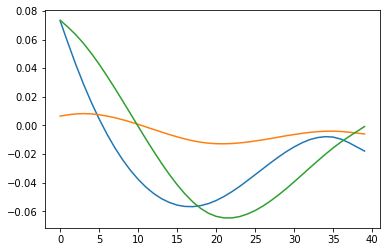

In [38]:
plt.plot(kmeans.cluster_centers_.T)

In [39]:
data_write = kmeans.labels_[np.newaxis, :]+1
nifti_4d = np.zeros(mask.shape + (data_write.shape[0],), 
                    dtype=data_write.dtype)
nifti_4d[mask, :] = data_write.T
nifti_out = nb.Nifti2Image(nifti_4d, mask_full.affine)
nb.save(nifti_out, 'hcp_fix_test3.nii')

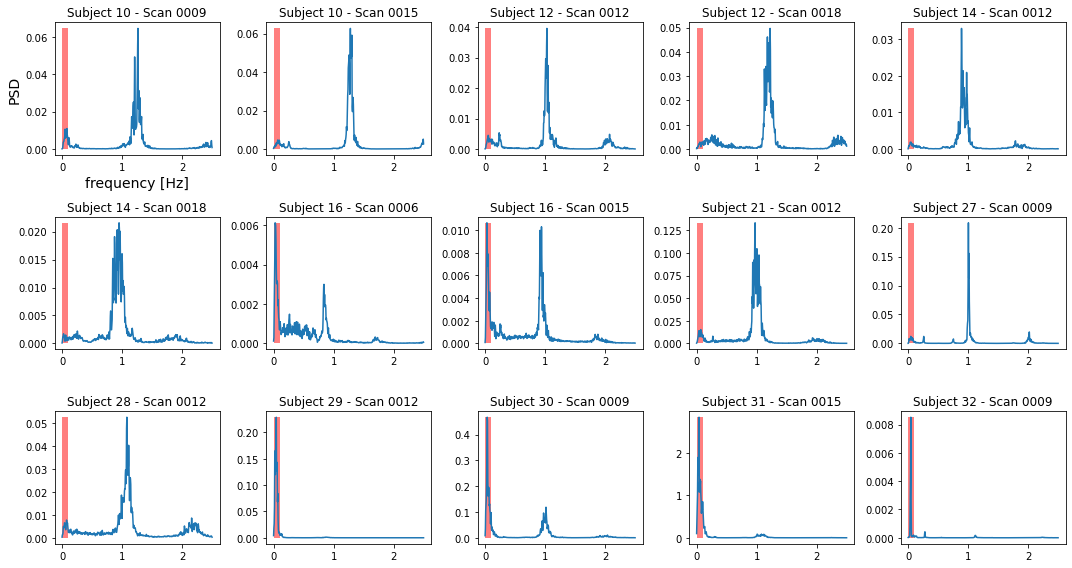

In [89]:
from scipy.io import loadmat
from scipy.signal import welch
import neurokit2 as nk

fig, axs = plt.subplots(3,5, figsize=(15,8))
for i, ax in zip(range(subject_list_chang.shape[0]), axs.flat):
    subj, scan = subject_list_chang.iloc[i,:][['subject', 'scan']].astype(int)
    
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
    physio_raw = loadmat(f'data/dataset_chang/physio/raw/sub_00{subj}-mr_{scan_str}-ecr_echo1_physOUT.mat', squeeze_me=True)
    sf_physio = 1/physio_raw['OUT_p']['dt_phys'].item()
    # Pull physio data into dict
    ppg = physio_raw['OUT_p']['card_dat'].item()
    resp = physio_raw['OUT_p']['resp'].item()['wave'].item()
    physio = {'ppg': ppg, 'resp': resp}
    physio_secs = len(physio['resp'])/sf_physio
    physio_resamp_n = int(physio_secs * 5)
    physio = {l: nk.signal_resample(physio[l], desired_length=physio_resamp_n, method='FFT') 
          for l in physio.keys()}
    f, pxx = welch(physio['ppg'], 5, nperseg=1000, noverlap=500)
    ax.plot(f, pxx)
    ax.set_title(f'Subject {subj} - Scan {scan_str}', fontsize=12)
    if i == 0:
        ax.set_xlabel('frequency [Hz]', fontsize=14)
        ax.set_ylabel('PSD', fontsize=14)
    f_low = f[f <= 0.1]
    ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)

fig.tight_layout()
plt.show()

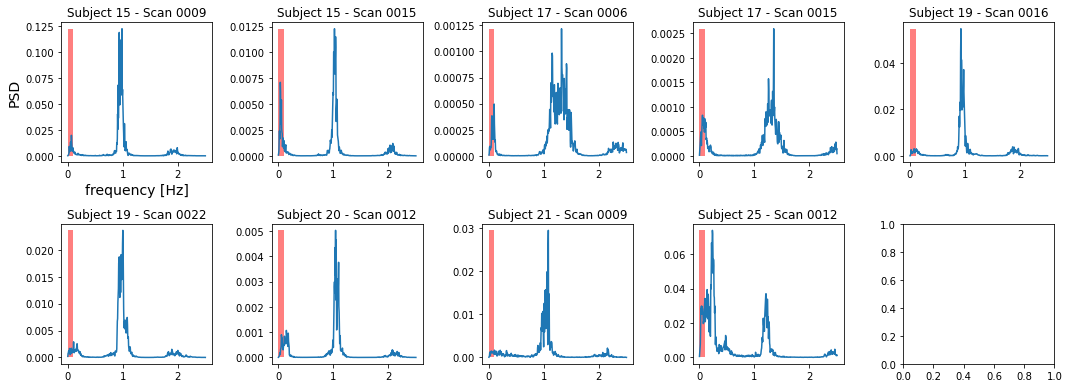

In [5]:
from scipy.io import loadmat
from scipy.signal import welch
import neurokit2 as nk

fig, axs = plt.subplots(2,5, figsize=(15,5.5))
for i, ax in zip(range(subject_list_chang_bh.shape[0]), axs.flat):
    subj, scan = subject_list_chang_bh.iloc[i,:][['subject', 'scan']].astype(int)
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
    physio_raw = loadmat(f'data/dataset_chang_bh/physio/raw/sub_00{subj}-mr_{scan_str}-adb_echo1_physOUT.mat', squeeze_me=True)
    sf_physio = 1/physio_raw['OUT_p']['dt_phys'].item()
    # Pull physio data into dict
    ppg = physio_raw['OUT_p']['card_dat'].item()
    resp = physio_raw['OUT_p']['resp'].item()['wave'].item()
    physio = {'ppg': ppg, 'resp': resp}
    physio_secs = len(physio['resp'])/sf_physio
    physio_resamp_n = int(physio_secs * 5)
    physio = {l: nk.signal_resample(physio[l], desired_length=physio_resamp_n, method='FFT') 
          for l in physio.keys()}
    f, pxx = welch(physio['ppg'], 5, nperseg=1000, noverlap=500)
    ax.plot(f, pxx)
    ax.set_title(f'Subject {subj} - Scan {scan_str}', fontsize=12)
    if i == 0:
        ax.set_xlabel('frequency [Hz]', fontsize=14)
        ax.set_ylabel('PSD', fontsize=14)
    f_low = f[f <= 0.1]
    ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)

fig.tight_layout()
plt.show()

In [157]:
from scipy.io import loadmat
from scipy.signal import welch
import neurokit2 as nk
subject_list_spreng = pd.read_csv('data/dataset_spreng/subject_list_spreng.csv')

fig, axs = plt.subplots(3,5, figsize=(15,5.5))
for i, (subj, ax) in enumerate(zip(subject_list_spreng.subject, axs.flat)):
    if i < 15:
        fp = f'data/dataset_spreng/physio/raw/{subj}_ses-1_task-rest_physio.tsv.gz'
        physio_df = pd.read_csv(fp, compression='gzip', sep='\t', header=None)
        subj_base = fp.rsplit('.tsv')[0]
        physio_json = json.load(open(f'{subj_base}.json'))
        physio_df.columns = physio_json['Columns']
        physio_df.rename(columns = {'cardiac': 'ppg', 'respiratory': 'resp'}, inplace=True)
        sf_physio = physio_json['SamplingFrequency']
        physio_secs = len(physio_df['ppg'])/sf_physio
        physio_resamp_n = int(physio_secs * 5)
        ppg = nk.signal_resample(physio_df['ppg'], desired_length=physio_resamp_n, method='FFT')
        f, pxx = welch(ppg, 5, nperseg=500, noverlap=50)
        ax.plot(f, pxx)
        ax.set_title(f'Subject {subj}', fontsize=12)
        if i == 0:
            ax.set_xlabel('frequency [Hz]', fontsize=14)
            ax.set_ylabel('PSD', fontsize=14)
        f_low = f[f <= 0.1]
        ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)

fig.tight_layout()
plt.show()

In [4]:
def load_hcp_task_event_file(ev_dir, task):
    if task == 'hcp_rel':
        rel = np.loadtxt(f'{ev_dir}/relation.txt', unpack=True)
        match = np.loadtxt(f'{ev_dir}/match.txt', unpack=True)
        all_trials = np.concatenate([rel, match], axis=1)
    elif task == 'hcp_wm':
        bk_str = ['0bk', '2bk']
        stimuli_str = ['body', 'faces', 'tools', 'places']
        all_trials = [np.loadtxt(f'{ev_dir}/{bk}_{stimuli}.txt', unpack=True) 
                      for bk in bk_str for stimuli in stimuli_str]
        all_trials = np.vstack(all_trials).T
    all_trials = {['onset','duration'][i]: all_trials[i] for i in range(2)}
    trials_df = pd.DataFrame(all_trials).sort_values(by='onset')
    return trials_df


<AxesSubplot:xlabel='time'>

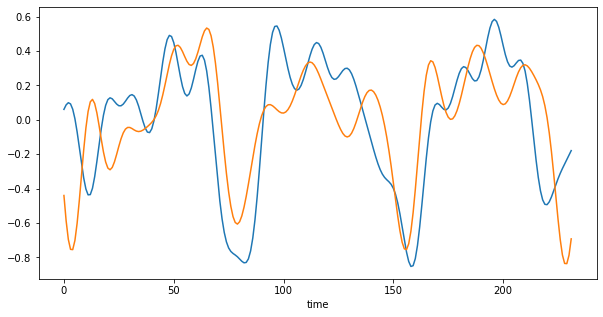

In [12]:
subject_list_task = pd.read_csv('data/dataset_hcp_task/subject_list_hcp_relational.csv')

physio_group = []
for subj, scan in zip(subject_list_task.subject, subject_list_task.lr):
    df = pd.read_csv(f'data/dataset_hcp_task/physio_rel/proc1_physio/{subj}_physio.csv')
    df = df.apply(lambda x: zscore(butterworth_filter(x, 0.01, 0.1, fs=fs_hcp, filter_type='bandpass')), axis=0)
    df['subj'] = subj
    df['time'] = df.index
    physio_group.append(df)

physio_concat = pd.concat(physio_group, axis=0, ignore_index=True)

event_blocks = []
for subj, scan in zip(subject_list_task.subject, subject_list_task.lr):
        event_dir = f'data/dataset_hcp_task/events_rel/{subj}_{scan}_EV'
        event_df = load_hcp_task_event_file(event_dir, 'hcp_rel')
        event_blocks.append(onsets_to_block(event_df, 232, 0.72))

fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(event_blocks[0])
physio_concat.groupby('time')['RESP_RATE_NK'].mean().plot(ax=ax, label='rate')
physio_concat.groupby('time')['RESP_RVT_NK'].mean().plot(ax=ax, label='volume')

In [35]:
task_fp = 'wm'
task = 'wm'
task_len = 405

subject_list_task = pd.read_csv(f'data/dataset_hcp_task/subject_list_hcp_{task_fp}.csv')
pca_output = pickle.load(open(f'results/pca/hcp_{task}_pca_group_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/hcp_{task}_pca_group_promax_results.pkl', 'rb'))
pc_ts = pca_output['pc_scores']
pc_ts_p = pca_output_p['pc_scores']

n_t = 0
pc_subj_hcp = {}
pc_p_subj_hcp = {}
for i, subj in enumerate(subject_list_task.subject):
    # Extract subject PC time series
    pc_subj_hcp[f'{subj}'] = pc_ts[n_t:(n_t+task_len),:]
    # Extract subject PC-Promax time series
    pc_p_subj_hcp[f'{subj}'] = pc_ts_p[n_t:(n_t+task_len),:]
    n_t += task_len

In [36]:
physio_group = []
hrf = get_hrf(30, 0.72, 'canonical')

for subj, scan in zip(subject_list_task.subject, subject_list_task.lr):
    df = pd.read_csv(f'data/dataset_hcp_task/physio_{task}/proc1_physio/{subj}_physio.csv')
    df = df.apply(lambda x: zscore(butterworth_filter(x, 0.01, 0.1, fs=fs_hcp, filter_type='bandpass')), axis=0)
    df['subj'] = subj
    df['time'] = df.index
    df['pc1'] = pc_subj_hcp[f'{subj}'][:,0]
    df['pc1_p'] = pc_p_subj_hcp[f'{subj}'][:,0]
    df['pc2_p'] = pc_p_subj_hcp[f'{subj}'][:,1]
    df['pc3_p'] = pc_p_subj_hcp[f'{subj}'][:,2]
    event_dir = f'data/dataset_hcp_task/events_{task}/{subj}_{scan}_EV'
    event_df = load_hcp_task_event_file(event_dir, f'hcp_{task}')
    event_blocks = onsets_to_block(event_df, task_len, 0.72)
    block_ts = np.zeros(df.shape[0])
    for block_i in event_blocks:
        block_ts[block_i] = 1
    df['task_design'] = block_ts
    conv_event_blocks = convolve_hrf(hrf, block_ts)
    df['task_design_hrf'] = conv_event_blocks
    physio_group.append(df)

physio_concat = pd.concat(physio_group, axis=0, ignore_index=True)

In [41]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(block_ts)
ax.plot(conv_event_blocks / conv_event_blocks.max())

physio_concat.groupby('time')['RESP_RVT_NK'].mean().plot(ax = ax)
# physio_concat.groupby('time')['PPG_LOW_NK'].mean().plot(ax = ax)

<AxesSubplot:xlabel='time'>

In [73]:
task_wm_res = pickle.load(open('hcp_rel_task_reg_results.pkl', 'rb'))

In [74]:
np.quantile(task_wm_res[1]['physio'], 0.6)

2.52679040568366

In [89]:
subject_list_hcp_master = pd.read_csv('data/dataset_hcp/subject_list_hcp_master.csv')

for subj, scan in zip(subject_list_hcp_master.subject, subject_list_hcp_master.lr):
    for task in ['1_rest', '_relational', '_wm']:
        try:
            physio_signals = np.loadtxt(f'data/dataset_hcp/test_physio/{subj}_{scan}{task}_physio.txt')
        except:
            continue
        physio_signals_df = pd.DataFrame({ 
         'resp': physio_signals[:,1],
         'ppg': physio_signals[:,2]
         })
        # Downsample to 100Hz (400Hz is unnecessary)
        physio_secs = physio_signals_df.shape[0]/400
        physio_resamp_n = int(physio_secs * 100)
        physio_signals_resamp = physio_signals_df.apply(
            nk.signal_resample, desired_length=physio_resamp_n, method='FFT', axis=0
        )
        fig, ax = plt.subplots(figsize=(10,8))
        ax.plot(physio_signals_resamp['resp'], label='resp')
        ax.plot(physio_signals_resamp['ppg'], alpha=0.5, label='ppg')
        ax.legend()
        plt.savefig(f'data/dataset_hcp/test_physio/{subj}_{scan}{task}_physio.png')
        plt.close()

In [275]:
from utils.load_write import convert_2d
recon_promax = []
nifti = nb.load(f'monash_pet_pca_group.nii')
mask = nb.load('masks/MNI152_T1_3mm_gray_mask.nii.gz').get_fdata()
nifti_data = nifti.get_fdata()*-1
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)

In [276]:
yeo = nb.load(f'data/templates/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz')
yeo_data = yeo.get_fdata()
yeo.uncache()
yeo_cluster = convert_2d(mask, yeo_data)

In [277]:
mean_clus = []
std_clus = []
for i in range(1,8):
    clus_i = np.where(yeo_cluster==i)[0]
    mean_clus.append(nifti_data[0,clus_i].mean())
    std_clus.append(nifti_data[0,clus_i].std())

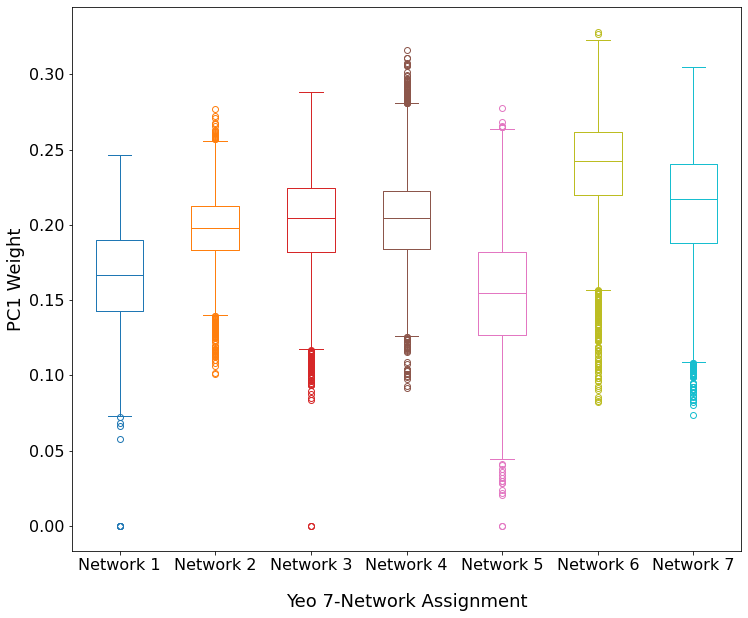

In [300]:
fig, ax = plt.subplots(figsize=(12,10))

tab_cmap = plt.cm.get_cmap('tab10')
np.random.seed(123)
net_labels = [f'Network {i+1}' for i in range(7)]

w = 0.8    # bar width
color_select = [0,1,3,5,6,8,9]
tab_cmap_select = [tab_cmap(c) for c in color_select]
x = np.arange(7)
for i in range(7):
    c = tab_cmap_select[i]
    ax.boxplot(bx_test[i], positions=[x[i]+1],
               widths=0.5,
               boxprops=dict(color=c),
               capprops=dict(color=c),
               whiskerprops=dict(color=c),
               flierprops=dict(color=c, markeredgecolor=c),
               medianprops=dict(color=c))
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylabel('PC1 Weight', fontsize=18)
ax.set_xlabel('Yeo 7-Network Assignment', fontsize=18, labelpad=20)
ax.set_xticks(x+1, net_labels, fontsize=16)


In [25]:
hcp_rel = pickle.load(open('hcp_rel_task_glm_results.pkl', 'rb'))

In [58]:
task_len = 200
fs_spreng = 1/3.0

subject_list_spreng = pd.read_csv(f'data/dataset_spreng/subject_list_spreng_subset.csv')
pca_output = pickle.load(open(f'spreng_pca_group_results.pkl', 'rb'))
pc_ts = pca_output['pc_scores']

n_t = 0
pc_subj_spreng = {}
for i, subj in enumerate(subject_list_spreng.subject):
    # Extract subject PC time series
    pc_subj_spreng[f'{subj}'] = pc_ts[n_t:(n_t+task_len),:]
    n_t += task_len


physio_group = []

for subj in subject_list_spreng.subject:
    df = pd.read_csv(f'data/dataset_spreng/physio/proc1_physio/{subj}_ses-1_task-rest_physio.csv')
    df['pc1'] = pc_subj_spreng[f'{subj}'][:,0]
    df = df.apply(lambda x: zscore(butterworth_filter(x, 0.01, 0.1, fs=fs_spreng, filter_type='bandpass')), axis=0)
    df['subj'] = subj
    df['time'] = df.index
    physio_group.append(df)

physio_concat = pd.concat(physio_group, axis=0, ignore_index=True)

In [59]:
physio_concat.corr()

,PPG_HR_NK,PPG_HR_W,PPG_LOW_NK,PPG_RMS_AMP,PPG_PEAK_AMP,RESP_RATE_NK,RESP_AMP_NK,RESP_RVT_NK,RESP_AMP_HILBERT,RESP_VAR_W,pc1,time
PPG_HR_NK,1.000000,0.319636,-0.029648,0.099995,-0.110849,0.043498,0.084922,0.083833,0.083683,0.108049,0.022537,-0.005290
PPG_HR_W,0.319636,1.000000,0.068013,-0.011316,-0.000974,-0.026689,0.054149,0.061573,0.064615,0.163970,0.029669,0.010245
PPG_LOW_NK,-0.029648,0.068013,1.000000,-0.327201,-0.195102,-0.018863,0.035540,-0.000366,0.032133,-0.020328,0.027877,0.001327
PPG_RMS_AMP,0.099995,-0.011316,-0.327201,1.000000,0.555532,-0.020599,-0.007033,0.001384,0.002514,0.052189,0.129424,0.003211
PPG_PEAK_AMP,-0.110849,-0.000974,-0.195102,0.555532,1.000000,-0.104745,-0.064543,-0.069969,-0.043168,-0.041075,0.166626,0.006940
RESP_RATE_NK,0.043498,-0.026689,-0.018863,-0.020599,-0.104745,1.000000,-0.098919,0.359392,-0.010196,-0.070222,-0.007813,-0.005831
RESP_AMP_NK,0.084922,0.054149,0.035540,-0.007033,-0.064543,-0.098919,1.000000,0.618720,0.902777,0.802455,-0.001954,0.001025
RESP_RVT_NK,0.083833,0.061573,-0.000366,0.001384,-0.069969,0.359392,0.618720,1.000000,0.741954,0.678827,0.015680,0.006817
RESP_AMP_HILBERT,0.083683,0.064615,0.032133,0.002514,-0.043168,-0.010196,0.902777,0.741954,1.000000,0.877827,0.015047,0.007476
RESP_VAR_W,0.108049,0.163970,-0.020328,0.052189,-0.041075,-0.070222,0.802455,0.678827,0.877827,1.000000,0.077533,0.007703


In [64]:
physio_concat[['pc1','RESP_RVT_NK']].iloc[800:1000].plot()

<AxesSubplot:>

In [60]:
physio_concat[['pc1','RESP_RVT_NK']].iloc[:200].plot()

<AxesSubplot:>

In [69]:
import json

sub-0019 :  10.2 50
sub-0023 :  10.2 50
sub-0035 :  10.2 50
sub-0040 :  10.2 50
sub-0046 :  10.20625 40
sub-0075 :  10.202916666666665 40
sub-0080 :  10.204583333333334 40
sub-0081 :  10.204166666666667 40
sub-0087 :  10.205416666666668 40
sub-0088 :  10.204583333333334 40
sub-0091 :  10.205416666666668 40
sub-0092 :  10.202083333333333 40
sub-0095 :  10.203333333333335 40
sub-0097 :  10.208333333333334 40
sub-0098 :  10.204583333333334 40
sub-0099 :  10.205833333333334 40
sub-0100 :  10.202916666666665 40
sub-0103 :  10.203333333333335 40
sub-0130 :  10.202083333333333 40
sub-0135 :  10.202499999999999 40
sub-0139 :  10.202916666666665 40
sub-0140 :  10.203333333333335 40
sub-0146 :  10.203750000000001 40
sub-0153 :  10.203750000000001 40
sub-0155 :  10.204583333333334 40
sub-0161 :  10.203750000000001 40
sub-0162 :  10.205416666666668 40
sub-0165 :  10.203333333333335 40
sub-0166 :  10.204583333333334 40
sub-0168 :  10.202916666666665 40
sub-0174 :  10.203333333333335 40
sub-0176 :  